Extração(LLM) - Recomendação (RecSys) - Review (LLM) 

## Imports

### Dataset

In [2]:
import pandas as pd
import openai # API openai
import zipfile # Extrair .zip
import json # Trabalhar com JSON
import re
import pickle
import numpy as np
from tqdm import tqdm
from numpy import log2

In [3]:
# Importando dados de treino e teste
with zipfile.ZipFile('../data/redial_dataset.zip', 'r') as z:
    z.extractall('../data/')

train_data = []
for line in open("../data/train_data.jsonl", "r"):
    train_data.append(json.loads(line))
print("Loaded {} train conversations".format(len(train_data)))


test_data = []
for line in open("../data/test_data.jsonl", "r"):
    test_data.append(json.loads(line))
print("Loaded {} test conversations".format(len(test_data)))

movies_w_mentions = pd.read_csv('../data/movies_with_mentions.csv')

Loaded 10006 train conversations
Loaded 1342 test conversations


In [4]:
test_data[232]

{'movieMentions': {'193168': 'Rush Hour  (1998)',
  '133381': 'The Juror (1996)',
  '112284': 'Ring  (1998)',
  '187028': 'It  (2017)',
  '118762': '21 Jump Street  (2012)'},
 'respondentQuestions': {'193168': {'suggested': 1, 'seen': 0, 'liked': 1},
  '133381': {'suggested': 1, 'seen': 2, 'liked': 2},
  '112284': {'suggested': 0, 'seen': 1, 'liked': 2},
  '187028': {'suggested': 0, 'seen': 0, 'liked': 2},
  '118762': {'suggested': 1, 'seen': 2, 'liked': 2}},
 'messages': [{'timeOffset': 0,
   'text': 'HI',
   'senderWorkerId': 997,
   'messageId': 209161},
  {'timeOffset': 1, 'text': 'hi', 'senderWorkerId': 1016, 'messageId': 209162},
  {'timeOffset': 5,
   'text': 'How are you?',
   'senderWorkerId': 997,
   'messageId': 209163},
  {'timeOffset': 7,
   'text': 'I like all sorts of movies',
   'senderWorkerId': 1016,
   'messageId': 209164},
  {'timeOffset': 8,
   'text': 'I am fine',
   'senderWorkerId': 1016,
   'messageId': 209165},
  {'timeOffset': 16,
   'text': 'Can you mention 

In [5]:
# Exemplo de conversa 
conversation = train_data[32]

# Mostrar de forma formatada
print("=== Conversa ID:", conversation["conversationId"], "===")
for msg in conversation["messages"]:
    sender = "Usuário 1" if msg["senderWorkerId"] == conversation["initiatorWorkerId"] else "Usuário 2"
    print(f"{sender}: {msg['text']}")

=== Conversa ID: 485 ===
Usuário 1: Hi can you help me find a musical
Usuário 2: hey what kind of movies interest you
Usuário 2: yes i would love to!
Usuário 1: I really like @127328 and @107350
Usuário 2: have you seen @172129 with Renee Zellwegger, Queen Latifa, and Catherine Zeta Jones
Usuário 2: I like @127328 too!
Usuário 2: oops, I meant @145997
Usuário 1: Yeah I have seen @145997 many times
Usuário 2: what about @124461 for something a little different or even @124268 which was more recent?
Usuário 1: I have not seen @124268 I think I may like that one
Usuário 2: The music is all from ABBA and it is so good
Usuário 2: I hope you will enjoy it as much as I do
Usuário 1: That is great that group does have some good music thanks for the help. Bye
Usuário 2: no problem bye


In [6]:
movie_mentions = conversation.get('movieMentions', {})

print(f"=== Conversa ID: {conversation['conversationId']} ===")

for msg in conversation["messages"]:
    sender = "User 1" if msg["senderWorkerId"] == conversation["initiatorWorkerId"] else "User 2"
    text = msg['text']
    
    # Substitui cada @movieId pelo título do filme
    for movie_id, movie_title in movie_mentions.items():
        text = text.replace(f'@{movie_id}', movie_title)
    
    print(f"{sender}: {text}")

=== Conversa ID: 485 ===
User 1: Hi can you help me find a musical
User 2: hey what kind of movies interest you
User 2: yes i would love to!
User 1: I really like Hairspray  (2007) and Sweeney Todd: The Demon Barber of Fleet Street  (2007)
User 2: have you seen Chicago 10  (2007) with Renee Zellwegger, Queen Latifa, and Catherine Zeta Jones
User 2: I like Hairspray  (2007) too!
User 2: oops, I meant Chicago  (2002)
User 1: Yeah I have seen Chicago  (2002) many times
User 2: what about White Christmas  (1954) for something a little different or even Mamma Mia!  (2008) which was more recent?
User 1: I have not seen Mamma Mia!  (2008) I think I may like that one
User 2: The music is all from ABBA and it is so good
User 2: I hope you will enjoy it as much as I do
User 1: That is great that group does have some good music thanks for the help. Bye
User 2: no problem bye


In [7]:
conversation = train_data[222]

# IDs de usuários
initiator_id = conversation["initiatorWorkerId"]
respondent_id = conversation["respondentWorkerId"]

print("ID do usuário que iniciou a conversa:", initiator_id)
print("ID do usuário que respondeu:", respondent_id)


ID do usuário que iniciou a conversa: 56
ID do usuário que respondeu: 60


## Tratamento e Limpeza dos datasets

In [8]:
def clean_data(dataset):
    """
    Remove diálogos inválidas do dataset 
    """

    invalid_indexes = []

    # Identifica diálogos inválidas
    for i, conv in enumerate(dataset):
        if (
            isinstance(conv.get("movieMentions"), list) # Se for lista em vez de dicionário
            or not isinstance(conv.get("movieMentions", {}), dict) # Se dicionário for inválido
            or "messages" not in conv # Diálogo sem mensagem
            or not conv["messages"] # Diálogo sem mensagem
        ):
            invalid_indexes.append(i)

    # Remove invalidos
    for i in sorted(invalid_indexes, reverse=True):
        del dataset[i]

    print(f"✅ Conversas válidas restantes: {len(dataset)}")
    print(f"🗑️ Conversas removidas: {len(invalid_indexes)}")

clean_data(train_data)
clean_data(test_data)

✅ Conversas válidas restantes: 10005
🗑️ Conversas removidas: 1
✅ Conversas válidas restantes: 1342
🗑️ Conversas removidas: 0


### Substituiçao Errados

In [9]:
import re
import copy
import math
import numpy as np
import pandas as pd
from collections import defaultdict

# -----------------------------
# 0) Helpers: parsing & normalize
# -----------------------------

_YEAR_RE = re.compile(r"\((\d{4})\)\s*$")

def has_year(title: str) -> bool:
    if not isinstance(title, str):
        return False
    return _YEAR_RE.search(title.strip()) is not None

def extract_year(title: str):
    if not isinstance(title, str):
        return None
    m = _YEAR_RE.search(title.strip())
    return int(m.group(1)) if m else None

def base_title(title: str) -> str:
    """
    Remove trailing '(YYYY)' and normalize spaces.
    Example:
      'American Pie  (1999)' -> 'American Pie'
      'American Pie ' -> 'American Pie'
    """
    if not isinstance(title, str):
        return ""
    t = title.strip()
    t = re.sub(r"\(\d{4}\)\s*$", "", t).strip()
    t = re.sub(r"\s+", " ", t).strip()
    return t

def norm_title(title: str) -> str:
    """Lower + remove extra whitespace (keeps punctuation)."""
    return base_title(title).lower().strip()

def safe_get_flags(conv, key):
    data = conv.get(key, {})
    return {} if isinstance(data, list) else data

# -----------------------------
# 1) Build candidate index from movies_w_mentions
# -----------------------------

def build_candidates_index(movies_w_mentions: pd.DataFrame):
    """
    Expects columns: movieId, movieName, nbMentions
    Returns:
      - base_norm -> list[{id, name, year, nb}]
      - id -> {name, year, nb, base_norm}
    """
    idx = defaultdict(list)
    by_id = {}

    required = {"movieId", "movieName"}
    missing = required - set(movies_w_mentions.columns)
    if missing:
        raise ValueError(f"movies_w_mentions is missing columns: {missing}")

    # nbMentions optional (fallback to 0)
    for _, row in movies_w_mentions.iterrows():
        mid = str(row["movieId"])
        name = row["movieName"]
        nb = int(row["nbMentions"]) if "nbMentions" in movies_w_mentions.columns and pd.notna(row["nbMentions"]) else 0

        y = extract_year(name)
        bnorm = norm_title(name)

        rec = {"id": mid, "name": name, "year": y, "nb": nb, "base_norm": bnorm}
        by_id[mid] = rec

        # Only index candidates that HAVE YEAR (you requested "substituir por filmes com data")
        if y is not None:
            idx[bnorm].append(rec)

    return idx, by_id

# -----------------------------
# 2) Scoring rule you asked for:
#    - if multiple candidates:
#        center_year = median(years of other movies w/ year in the conversation)
#        pick argmin |year-center| - 0.5*log1p(nbMentions)
#    - if no center_year: pick max nbMentions
# -----------------------------

def choose_candidate(candidates, center_year):
    """
    candidates: list of recs with year != None
    center_year: int or None
    """
    if not candidates:
        return None

    if center_year is None:
        # pick most mentioned
        return max(candidates, key=lambda r: (r["nb"], r["year"] if r["year"] is not None else -1))

    def score(r):
        # abs distance - 0.5*log1p(nbMentions)
        return abs(r["year"] - center_year) - 0.5 * math.log1p(max(r["nb"], 0))

    # minimize score, tie-break by higher nbMentions
    return min(candidates, key=lambda r: (score(r), -r["nb"]))

# -----------------------------
# 3) Merge flags safely when old_id -> new_id
#    (Optional but recommended to avoid losing labels)
# -----------------------------

def merge_question_flags(old_flags: dict, new_flags: dict):
    """
    Both dicts can have keys: suggested, seen, liked
    We'll keep "stronger" signal:
      liked order: 1 (positive) > 0 (negative) > 2/None (unknown)
      seen  order: 1 (seen)     > 0 (not seen) > 2/None (unknown)
      suggested: max
    """
    def pick(order, a, b):
        # order: list of preferred values
        for v in order:
            if a == v or b == v:
                return v
        # fallback: keep b if exists else a
        return b if b is not None else a

    out = {}
    old_flags = old_flags or {}
    new_flags = new_flags or {}

    out["suggested"] = max(old_flags.get("suggested", 0), new_flags.get("suggested", 0))

    out["liked"] = pick([1, 0, 2], old_flags.get("liked", None), new_flags.get("liked", None))
    out["seen"]  = pick([1, 0, 2], old_flags.get("seen", None),  new_flags.get("seen", None))

    # keep any extra fields if exist
    for k, v in old_flags.items():
        if k not in out:
            out[k] = v
    for k, v in new_flags.items():
        if k not in out:
            out[k] = v

    return out

# -----------------------------
# 4) Apply replacement inside ONE conversation
# -----------------------------

def get_center_year_from_conv(conv, exclude_ids=None):
    """
    Median year of OTHER movies in movieMentions that have year in the title.
    exclude_ids: set of ids (strings) to ignore when computing center.
    """
    exclude_ids = exclude_ids or set()
    mentions = conv.get("movieMentions", {}) or {}
    years = []
    for mid, title in mentions.items():
        mid = str(mid)
        if mid in exclude_ids:
            continue
        y = extract_year(title)
        if y is not None:
            years.append(y)
    return int(np.median(years)) if years else None

def apply_replacement_in_conv(conv, old_id: str, new_rec: dict):
    """
    Mutates conv in-place:
      - movieMentions: replace key old_id -> new_id (and set title to candidate name)
      - initiatorQuestions/respondentQuestions: move/merge flags
      - messages: replace '@old_id' -> '@new_id'
    """
    new_id = str(new_rec["id"])
    new_name = new_rec["name"]

    # 1) movieMentions
    mentions = conv.get("movieMentions", {})
    if isinstance(mentions, dict):
        # remove old, add/overwrite new
        if old_id in mentions:
            mentions.pop(old_id, None)
        # Ensure new appears with name WITH YEAR
        mentions[new_id] = new_name
        conv["movieMentions"] = mentions

    # 2) Questions flags: initiatorQuestions, respondentQuestions
    for key in ("initiatorQuestions", "respondentQuestions"):
        q = safe_get_flags(conv, key)
        if not q:
            # if list or empty, just skip
            continue
        old_flags = q.get(old_id)
        new_flags = q.get(new_id)
        if old_flags is not None or new_flags is not None:
            merged = merge_question_flags(old_flags or {}, new_flags or {})
            q[new_id] = merged
            q.pop(old_id, None)
            conv[key] = q

    # 3) Messages: replace @old_id with @new_id
    msgs = conv.get("messages", [])
    if isinstance(msgs, list):
        old_tag = f"@{old_id}"
        new_tag = f"@{new_id}"
        for m in msgs:
            txt = m.get("text")
            if isinstance(txt, str) and old_tag in txt:
                m["text"] = txt.replace(old_tag, new_tag)
        conv["messages"] = msgs

    return conv

# -----------------------------
# 5) Main: fix_missing_years_in_dataset (NO mutation of original)
# -----------------------------

def fix_missing_years_in_dataset(
    dataset,
    movies_w_mentions: pd.DataFrame,
    verbose=True,
    max_log_examples=10
):
    """
    Returns:
      fixed_dataset, report

    Rules:
      - if missing-year title has no substitute: skip
      - if exactly 1 substitute: replace
      - if multiple substitutes:
          center_year = median(years of other movies with year in THIS conversation)
          if center_year exists: choose min |year-center| - 0.5*log1p(nbMentions)
          else: choose max nbMentions
    """
    cand_idx, by_id = build_candidates_index(movies_w_mentions)
    fixed = copy.deepcopy(dataset)

    report = {
        "total_convs": len(dataset),
        "missing_year_items": 0,
        "replaced": 0,
        "skipped_no_candidate": 0,
        "skipped_bad_mentions": 0,
        "multi_candidate": 0,
        "examples": {
            "skipped_no_candidate": [],
            "multi_candidate_choices": [],
            "replaced": [],
        }
    }

    for conv in fixed:
        mentions = conv.get("movieMentions", {})
        if not isinstance(mentions, dict) or not mentions:
            report["skipped_bad_mentions"] += 1
            continue

        # find ids with missing year in their movieMentions title
        missing_ids = []
        for mid, title in mentions.items():
            mid = str(mid)
            if isinstance(title, str) and not has_year(title):
                missing_ids.append(mid)

        if not missing_ids:
            continue

        # process each missing id (one by one)
        for old_id in missing_ids:
            old_title = mentions.get(old_id)
            if not isinstance(old_title, str):
                continue

            report["missing_year_items"] += 1

            bnorm = norm_title(old_title)
            candidates = cand_idx.get(bnorm, [])

            if not candidates:
                report["skipped_no_candidate"] += 1
                if len(report["examples"]["skipped_no_candidate"]) < max_log_examples:
                    report["examples"]["skipped_no_candidate"].append({
                        "conversationId": conv.get("conversationId"),
                        "old_id": old_id,
                        "old_title": old_title
                    })
                continue

            # compute center_year excluding this missing movie id
            center_year = get_center_year_from_conv(conv, exclude_ids={old_id})

            chosen = None
            if len(candidates) == 1:
                chosen = candidates[0]
            else:
                report["multi_candidate"] += 1
                chosen = choose_candidate(candidates, center_year)

                if len(report["examples"]["multi_candidate_choices"]) < max_log_examples:
                    report["examples"]["multi_candidate_choices"].append({
                        "conversationId": conv.get("conversationId"),
                        "old_id": old_id,
                        "old_title": old_title,
                        "center_year": center_year,
                        "candidates": [(c["id"], c["name"], c["year"], c["nb"]) for c in candidates],
                        "chosen": (chosen["id"], chosen["name"], chosen["year"], chosen["nb"]) if chosen else None
                    })

            if chosen is None:
                report["skipped_no_candidate"] += 1
                continue

            # If chosen id equals old id, nothing to do (rare)
            if str(chosen["id"]) == str(old_id):
                continue

            # Apply replacement in conv
            apply_replacement_in_conv(conv, str(old_id), chosen)
            report["replaced"] += 1

            if len(report["examples"]["replaced"]) < max_log_examples:
                report["examples"]["replaced"].append({
                    "conversationId": conv.get("conversationId"),
                    "old_id": old_id,
                    "old_title": old_title,
                    "new_id": str(chosen["id"]),
                    "new_title": chosen["name"],
                    "center_year": center_year
                })

            # update mentions ref (since we mutated it)
            mentions = conv.get("movieMentions", {})

    if verbose:
        print("=" * 70)
        print("✅ fix_missing_years_in_dataset — Report")
        print("=" * 70)
        print(f"Convs:                 {report['total_convs']}")
        print(f"Missing-year items:     {report['missing_year_items']}")
        print(f"Replaced:               {report['replaced']}")
        print(f"Multi-candidate cases:  {report['multi_candidate']}")
        print(f"Skipped (no candidate): {report['skipped_no_candidate']}")
        print(f"Skipped (bad mentions): {report['skipped_bad_mentions']}")
        print("=" * 70)

    return fixed, report

# -----------------------------
# 6) Convenience: show which ones were skipped
# -----------------------------

def show_skipped_cases(report, n=10):
    print("\n--- Skipped: no candidate ---")
    for ex in report["examples"]["skipped_no_candidate"][:n]:
        print(ex)

    print("\n--- Multi-candidate choices ---")
    for ex in report["examples"]["multi_candidate_choices"][:n]:
        print(ex)

    print("\n--- Replaced examples ---")
    for ex in report["examples"]["replaced"][:n]:
        print(ex)

# -----------------------------
# 7) USAGE EXAMPLE
# -----------------------------
# movies_w_mentions_df = pd.read_csv("movies_w_mentions.csv")  # you already have it
# fixed_test_data, fix_report = fix_missing_years_in_dataset(test_data, movies_w_mentions_df, verbose=True)
# show_skipped_cases(fix_report, n=10)




test_data, fix_report = fix_missing_years_in_dataset(test_data, movies_w_mentions, verbose=True)
train_data, fix_report = fix_missing_years_in_dataset(train_data, movies_w_mentions, verbose=True)

show_skipped_cases(fix_report, n=10)

✅ fix_missing_years_in_dataset — Report
Convs:                 1342
Missing-year items:     322
Replaced:               72
Multi-candidate cases:  7
Skipped (no candidate): 250
Skipped (bad mentions): 0
✅ fix_missing_years_in_dataset — Report
Convs:                 10005
Missing-year items:     3026
Replaced:               575
Multi-candidate cases:  83
Skipped (no candidate): 2451
Skipped (bad mentions): 0

--- Skipped: no candidate ---
{'conversationId': '395', 'old_id': '204322', 'old_title': 'South Park'}
{'conversationId': '418', 'old_id': '166069', 'old_title': 'Kill Bill'}
{'conversationId': '426', 'old_id': '104253', 'old_title': 'The Perks of Being a Wallflower '}
{'conversationId': '458', 'old_id': '125954', 'old_title': 'Star Trek: Of Gods and Men'}
{'conversationId': '463', 'old_id': '88960', 'old_title': 'The Naked Gun'}
{'conversationId': '475', 'old_id': '183056', 'old_title': 'The Big Lebowski'}
{'conversationId': '484', 'old_id': '103291', 'old_title': 'Eddie Murphy De

## Extração de itens e Montagem Matriz Usuário-Item (Offline)

### DF offline

In [20]:



def extract_interactions_crag_compliant(conv):
    """
    1. Usa movieMentions (Robustez de extração).
    2. MAS filtra explícitos 'liked=0' (Protocolo CRAG: remove negativos).
    3. Define User = ConversationId (Protocolo CRAG: Pseudo-user).
    """
    rows = []
    
    # OPÇÃO A: Protocolo CRAG estrito (Pseudo-User) 
    # user_id = conv.get("conversationId") 
    
    # OPÇÃO B: Sua abordagem (User real - Geralmente melhor performance)
    user_id = conv.get("conversationId")
    
    # O "ouro" da extração textual
    mentions = conv.get("movieMentions", {})
    
    # O "ouro" do sentimento (para filtrar negativos)
    # Precisamos checar tanto o initiator quanto o respondent para saber o sentimento
    init_q = conv.get("initiatorQuestions", {})
    resp_q = conv.get("respondentQuestions", {})
    
    # Helper para checar sentimento
    def is_explicitly_liked(mid_str):
        # Verifica Iniciador (Seeker)
        if mid_str in init_q:
            val = init_q[mid_str].get('liked')
            # Aceita se for 1 OU 2 (ou True)
            if val == 1:
                return True
        return False

    if user_id and isinstance(mentions, dict):
        for movie_id_str in mentions.keys():
            try:
                # CRAG: "exclude these items [negatively mentioned]" 
                if is_explicitly_liked(movie_id_str):
                    rows.append((user_id, int(movie_id_str), 1))
                
            except ValueError:
                continue
                
    return rows

def build_redial_interaction_df_robust(dataset):
    all_rows = []
    for conv in dataset:
        all_rows.extend(extract_interactions_crag_compliant(conv))
        
    df = pd.DataFrame(all_rows, columns=["userId", "movieId", "rating"])
    # Remove duplicatas (se o filme foi mencionado 2x na mesma conversa, conta como 1)
    df = df.drop_duplicates()
    return df

# --- RE-GERAR DATAFRAMES ---
print("Extraindo dados com metodologia Robusta (Menções)...")
df_train = build_redial_interaction_df_robust(train_data)
df_test = build_redial_interaction_df_robust(test_data)



print(df_train.head())
print(df_train.shape)

print(df_test.head())
print(df_test.shape)


#(5684, 3)

Extraindo dados com metodologia Robusta (Menções)...
  userId  movieId  rating
0    391   203371       1
1    391    84779       1
2    391   122159       1
3    391   151313       1
4    391   191602       1
(42320, 3)
  userId  movieId  rating
0  20001   111776       1
1  20001   151656       1
2  20001   134643       1
3  20001    94688       1
4  20041   125431       1
(5684, 3)


In [21]:
def extract_interactions_crag_compliant(conv, conv_idx):
    """
    1. Usa movieMentions (Robustez de extração).
    2. Define User = Índice da Conversa (Session-based puro: 0, 1, 2...).
    3. Input Permissivo: Aceita 1 (Like) e 2 (Mention/Did not say) para densidade.
    """
    rows = []
    
    # MUDANÇA AQUI: O ID do usuário passa a ser o índice sequencial da lista
    # Isso garante unicidade absoluta por sessão (Session-based)
    user_id = conv_idx
    
    # O "ouro" da extração textual
    mentions = conv.get("movieMentions", {})
    
    # Metadados para filtrar dislikes
    init_q = conv.get("initiatorQuestions", {})


    # Helper para checar sentimento (Ajustado para Input Permissivo)
    def is_valid_input(mid_str):
        # Se não tem metadados (init_q), assumimos que a menção é válida (Neutro/2 implícito)
        if mid_str not in init_q:
            return True 
            
        val = init_q[mid_str].get('liked')
        
        # Aceita se estiver na lista [1, 2]
        # Se for 0 (Dislike), retorna False
        if val == 1:
            return True
            
        return False

    if isinstance(mentions, dict):
        for movie_id_str in mentions.keys():
            try:
                # CRAG: "exclude these items [negatively mentioned]" 
                if is_valid_input(movie_id_str):
                    rows.append((user_id, int(movie_id_str), 1))
                
            except ValueError:
                continue
                
    return rows

def build_redial_interaction_df_robust(dataset):
    all_rows = []
    
    # MUDANÇA AQUI: Usamos enumerate para gerar o ID sequencial (0, 1, 2...)
    # Exatamente como "for instance in instances", mas capturando o índice.
    print("Extraindo interações (Session-based Index)...")
    
    for idx, conv in tqdm(enumerate(dataset), total=len(dataset)):
        # Passamos 'conv' e o 'idx' para a função
        all_rows.extend(extract_interactions_crag_compliant(conv, idx))
        
    df = pd.DataFrame(all_rows, columns=["userId", "movieId", "rating"])
    
    # Remove duplicatas (se o filme foi mencionado 2x na mesma conversa)
    df = df.drop_duplicates()
    
    return df   

# --- RE-GERAR DATAFRAMES ---
print("Extraindo dados com metodologia Robusta (Menções)...")
df_train = build_redial_interaction_df_robust(train_data)
df_test = build_redial_interaction_df_robust(test_data)



print(df_train.head())
print(df_train.shape)

print(df_test.head())
print(df_test.shape)

Extraindo dados com metodologia Robusta (Menções)...
Extraindo interações (Session-based Index)...


100%|██████████| 10005/10005 [00:00<00:00, 282622.10it/s]


Extraindo interações (Session-based Index)...


100%|██████████| 1342/1342 [00:00<00:00, 318224.56it/s]

   userId  movieId  rating
0       0   203371       1
1       0    84779       1
2       0   122159       1
3       0   151313       1
4       0   191602       1
(43065, 3)
   userId  movieId  rating
0       0   111776       1
1       0   151656       1
2       0   134643       1
3       0    94688       1
4       1   125431       1
(5774, 3)


#### Filtrar por interações



In [22]:
# movie_counts = df_train['movieId'].value_counts()
# popular_movies = movie_counts[movie_counts >= 0].index.tolist()
# df_train = df_train[df_train['movieId'].isin(popular_movies)]
# df_test  = df_test[df_test['movieId'].isin(popular_movies)]

print(df_train.head())
print(df_train.shape)

print(df_test.head())
print(df_test.shape)

# (42320, 3)
# (5684, 3)



   userId  movieId  rating
0       0   203371       1
1       0    84779       1
2       0   122159       1
3       0   151313       1
4       0   191602       1
(43065, 3)
   userId  movieId  rating
0       0   111776       1
1       0   151656       1
2       0   134643       1
3       0    94688       1
4       1   125431       1
(5774, 3)


### Matrix Factorization

In [23]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix



def create_sparse_matrix(df, user_mapper, movie_mapper, shape):
    """
        Cria matriz esparsa a partir de DataFrame
        user_mapper e movie_mapper são dicionarios do mapeamento
    """

    df_mapped = df.copy()

    # Faz mapeamento pois matrizes esparsas só aceitam índices inteiros começando em 0, e nao podem ser enormes
    
    df_mapped['user_index'] = df_mapped['userId'].map(user_mapper)#.astype('Int64')
    df_mapped['movie_index'] = df_mapped['movieId'].map(movie_mapper)#.astype('Int64')
    
    # remove linhas com NaN em índices ou rating inválido
    df_mapped = df_mapped.dropna(subset=['user_index', 'movie_index', 'rating'])
    df_mapped = df_mapped[df_mapped['rating'] > 0]

    # Remove duplicatas
    df_mapped = df_mapped.drop_duplicates(subset=['user_index', 'movie_index'], keep='last')
    
    # Cria matriz esparsa
    matrix = csr_matrix(
        (df_mapped['rating'].astype(float),
         (df_mapped['user_index'], #.astype('Int64')
          df_mapped['movie_index'])),#.astype('Int64')
        shape=shape
    )
    return matrix



In [24]:
#Utility matrix (user-item)

np.random.seed(42)

#all_data = pd.concat([df_train, df_test]) # Concatena train + test para garantir que todos os IDs estejam mapeados


user_ids = sorted(df_train['userId'].unique())
movie_ids = sorted(df_test['movieId'].unique())

user_mapper = {u: i for i, u in enumerate(user_ids)}
movie_mapper = {m: i for i, m in enumerate(movie_ids)}

n_users = len(user_mapper)
n_movies = len(movie_mapper)



train_user_item_sparse = create_sparse_matrix(df_train, user_mapper, movie_mapper, (n_users, n_movies))
test_user_item_sparse = create_sparse_matrix(df_test, user_mapper, movie_mapper, (n_users, n_movies))


train_item_user_sparse = train_user_item_sparse.T.tocsr()
test_item_user_sparse  = test_user_item_sparse.T.tocsr()








In [25]:
nonzero_cols = train_user_item_sparse[:10].nonzero()[1]
unique_cols = np.unique(nonzero_cols)

# pegar apenas os 6 primeiros filmes relevantes
selected_cols = unique_cols[:6]

# recorte da matriz
small_matrix = train_user_item_sparse[:10, selected_cols].toarray()

df_view = pd.DataFrame(
    small_matrix,
    columns=[f"Movie_{c}" for c in selected_cols],
    index=[f"User_{i}" for i in range(10)]
)

print(df_view)




        Movie_66  Movie_116  Movie_175  Movie_206  Movie_214  Movie_314
User_0       0.0        0.0        0.0        0.0        0.0        0.0
User_1       0.0        0.0        0.0        0.0        0.0        1.0
User_2       1.0        1.0        0.0        1.0        0.0        1.0
User_3       0.0        0.0        0.0        0.0        0.0        0.0
User_4       0.0        0.0        0.0        0.0        0.0        0.0
User_5       0.0        0.0        0.0        0.0        0.0        0.0
User_6       0.0        0.0        0.0        0.0        0.0        0.0
User_7       0.0        1.0        0.0        0.0        1.0        0.0
User_8       0.0        0.0        0.0        0.0        0.0        0.0
User_9       0.0        0.0        1.0        0.0        0.0        0.0


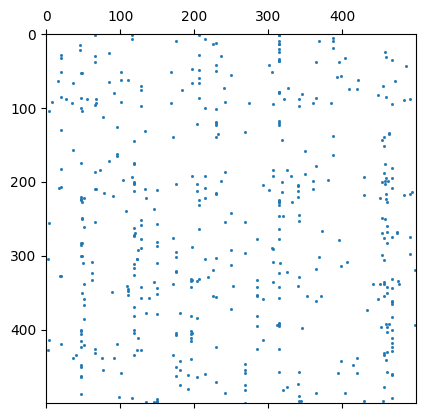

In [26]:
import matplotlib.pyplot as plt
plt.spy(train_user_item_sparse[:500, :500], markersize=1)
plt.show()


In [27]:
import numpy as np

def matrix_stats(M):


    print(f"Dimensões (usuários x itens): {M.shape}")
    print(f"Número total de elementos: {M.shape[0] * M.shape[1]:,}")
    
    # Elementos não nulos
    nnz = M.nnz

    # Densidade / Sparsidade
    density = nnz / (M.shape[0] * M.shape[1])
    print(f"Densidade: {density:.6f}")
    print(f"Esparsidade: {1 - density:.6f}")


    print(f"Média dos ratings: {M.data.mean():.2f}")


# Chamada:
matrix_stats(train_user_item_sparse)


Dimensões (usuários x itens): (9881, 1715)
Número total de elementos: 16,945,915
Densidade: 0.001814
Esparsidade: 0.998186
Média dos ratings: 1.00


In [28]:


with open("./variables/train_user_item_sparse.pkl", "wb") as f:
    pickle.dump(train_user_item_sparse, f)

with open("./variables/test_user_item_sparse.pkl", "wb") as f:
    pickle.dump(test_user_item_sparse, f)

In [29]:
with open("./variables/train_user_item_sparse.pkl", "rb") as f:
    train_user_item_sparse = pickle.load(f)

with open("./variables/test_user_item_sparse.pkl", "rb") as f:
    test_user_item_sparse = pickle.load(f)
    

## Extração de Itens (LLM)

### Chave API Open AI

In [7]:
from openai import OpenAI
import asyncio
from openai import AsyncOpenAI
from dotenv import load_dotenv
import os


In [8]:
#Chave API
load_dotenv() 
API_KEY = os.getenv("API_KEY")

client = OpenAI(api_key=API_KEY)
async_client = AsyncOpenAI(api_key=API_KEY)

In [9]:

response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "user", "content": "oi, digite 112233 e uma frase qualquer"}
    ]
)

print(response.choices[0].message.content)




112233 

A vida é feita de escolhas, faça as suas com sabedoria.


### Dataset: Ids -> Filmes

In [347]:

# Troca ids por nome dos filmes

import copy

def id_to_title(dataset):
  
    dataset_titled = copy.deepcopy(dataset)

    # Acessando conversa dentro das mensagens
    for conv in dataset_titled:
        message = conv.get("messages", {}) 
        mentions = conv.get("movieMentions", {})
        
        # Acessando texto dentro da conversa 
        for text in message:
            utt = text.get("text", {})
            #print(text)
            
            # Itera filmes mencionados
            for id, title in mentions.items(): # Mapeando id nome
                tag = f"@{id}"
                if tag in utt:
                    utt = utt.replace(tag,title) # Trocando id por filme
                    #print(utt_new)
                    
                    
            # Trocando o texto
            text["text"] = utt

                
    return dataset_titled

    
train_data_titled = id_to_title(train_data)   
test_data_titled = id_to_title(test_data)   


test_data_titled[42]



{'movieMentions': {'119144': 'Wonder Woman  (2017)',
  '77610': 'Sky High  (2003)',
  '133236': 'X-Men: Apocalypse (2016)',
  '177915': 'Uncle Buck',
  '134885': 'The Hunger Games  (2012)',
  '100750': 'The Hunger Games: Catching Fire (2013)',
  '181715': 'Logan  (2017)'},
 'respondentQuestions': {'119144': {'suggested': 1, 'seen': 0, 'liked': 1},
  '77610': {'suggested': 0, 'seen': 1, 'liked': 1},
  '133236': {'suggested': 1, 'seen': 2, 'liked': 2},
  '177915': {'suggested': 1, 'seen': 2, 'liked': 2},
  '134885': {'suggested': 1, 'seen': 1, 'liked': 1},
  '100750': {'suggested': 1, 'seen': 1, 'liked': 1},
  '181715': {'suggested': 1, 'seen': 0, 'liked': 2}},
 'messages': [{'timeOffset': 0,
   'text': 'Hi there are you interested in some classic comedies?',
   'senderWorkerId': 959,
   'messageId': 205056},
  {'timeOffset': 17,
   'text': 'I am actually looking for movies for my 12 yr olds sleepover',
   'senderWorkerId': 979,
   'messageId': 205057},
  {'timeOffset': 22,
   'text': 'T

### Formatação Conversa

In [171]:

# Formatar conversa para envio para LLM. Imitando ao maximo o que seria em um exemplo real
# quem mandou a mensagem e seu conteudo

def extract_text(dataset):
    # Lista que vai guardar os textos de todas as conversas
    all_formatted_texts = []

    for conv in dataset:
        
        user_id = conv['initiatorWorkerId']      # Usuário 
        recommender_id = conv['respondentWorkerId'] # Sistema 

        formatted_text_lines = []

        # Loop pelas mensagens da conversa atual
        for msg in conv.get('messages', []):
            sender_id = msg['senderWorkerId']
            text = msg['text'] 
            
            # Identifica de quem é a msg
            role = "Unknown" # Valor padrão
            if sender_id == user_id:
                role = "User"
            elif sender_id == recommender_id:
                role = "System"

            # Formata a linha e adiciona
            formatted_text_lines.append(f"{role}: {text}")
        
        # Junta as linhas dessa conversa e adiciona na lista final
        full_conversation = "\n".join(formatted_text_lines)
        all_formatted_texts.append(full_conversation)
    
    return all_formatted_texts


test_data_formatted = extract_text(test_data_titled)
print(test_data_formatted[232])




# {'movieMentions': {'111776': 'Super Troopers (2001)',
#   '91481': 'Beverly Hills Cop (1984)',
#   '151656': 'Police Academy  (1984)',
#   '134643': 'American Pie  (1999)',
#   '192131': 'American Pie ',
#   '124771': '48 Hrs. (1982)',
#   '94688': 'Police Academy 2: Their First Assignment (1985)',
#   '101794': 'Lethal Weapon (1987)'},


#  'respondentQuestions': {'111776': {'suggested': 0, 'seen': 1, 'liked': 1}, OK
#   '91481': {'suggested': 1, 'seen': 2, 'liked': 2},
#   '151656': {'suggested': 1, 'seen': 0, 'liked': 1}, OK
#   '134643': {'suggested': 0, 'seen': 1, 'liked': 1},
#   '192131': {'suggested': 0, 'seen': 1, 'liked': 1},
#   '124771': {'suggested': 1, 'seen': 2, 'liked': 2},
#   '94688': {'suggested': 1, 'seen': 0, 'liked': 1},
#   '101794': {'suggested': 1, 'seen': 0, 'liked': 2}},


System: HI
User: hi
System: How are you?
User: I like all sorts of movies
User: I am fine
User: Can you mention some?
User: I like comedu
System: Okay what about Rush Hour  (1998)
User: comedy and action
User: Yes good suggestion!
System: Good!
User: I also like scary ones too
User: What else?
System: What about 21 Jump Street  (2012)
User: Should I see It  (2017) ?
System: Im not a horror fan!
User: Ok I can watch that. It's been so long ago
System: Yeah for me too
User: Good to watch on friday night lol
User: and eat popcorn.
System: Have fun with that!
User: Sometimes I will watch Ring  (1998)
User: What other movies you can tell me to watch?
System: what about The Juror (1996)
System: Its been a long time for me
User: great!! thanks bye!
System: Bye


In [ ]:
# 'respondentQuestions': {
#   'Rush Hour  (1998)': {'suggested': 1, 'seen': 0, 'liked': 1},
#   '21 Jump Street  (2012)': {'suggested': 1, 'seen': 2, 'liked': 2},
#   ' It  (2017)': {'suggested': 0, 'seen': 1, 'liked': 2},
#   'Ring  (1998)': {'suggested': 0, 'seen': 0, 'liked': 2},
#   'The Juror (1996)': {'suggested': 1, 'seen': 2, 'liked': 2}},

#  'initiatorQuestions': {
#   'Rush Hour  (1998)': {'suggested': 1, 'seen': 1, 'liked': 1},
#   '21 Jump Street  (2012)': {'suggested': 1, 'seen': 0, 'liked': 1},
#   ' It  (2017)': {'suggested': 1, 'seen': 1, 'liked': 1},
#   'Ring  (1998)': {'suggested': 0, 'seen': 1, 'liked': 1},
#   'The Juror (1996)': {'suggested': 1, 'seen': 1, 'liked': 1}}}

In [172]:
test_data[232]

{'movieMentions': {'193168': 'Rush Hour  (1998)',
  '133381': 'The Juror (1996)',
  '112284': 'Ring  (1998)',
  '187028': 'It  (2017)',
  '118762': '21 Jump Street  (2012)'},
 'respondentQuestions': {'193168': {'suggested': 1, 'seen': 0, 'liked': 1},
  '133381': {'suggested': 1, 'seen': 2, 'liked': 2},
  '112284': {'suggested': 0, 'seen': 1, 'liked': 2},
  '187028': {'suggested': 0, 'seen': 0, 'liked': 2},
  '118762': {'suggested': 1, 'seen': 2, 'liked': 2}},
 'messages': [{'timeOffset': 0,
   'text': 'HI',
   'senderWorkerId': 997,
   'messageId': 209161},
  {'timeOffset': 1, 'text': 'hi', 'senderWorkerId': 1016, 'messageId': 209162},
  {'timeOffset': 5,
   'text': 'How are you?',
   'senderWorkerId': 997,
   'messageId': 209163},
  {'timeOffset': 7,
   'text': 'I like all sorts of movies',
   'senderWorkerId': 1016,
   'messageId': 209164},
  {'timeOffset': 8,
   'text': 'I am fine',
   'senderWorkerId': 1016,
   'messageId': 209165},
  {'timeOffset': 16,
   'text': 'Can you mention 

### Extração

#### Prompt

In [ ]:
PROMPT_LLM_EXTRACTION = """
Pretend you are a data extraction system for a movie recommender.

You will be given a full conversation between a user and a system. 
Each line begins with User: or System:

Your task is to extract movies that represent the USER'S PREFERENCES.

CRITICAL LOGIC:
2. VERY POSITIVE (Really Likes/Accept Well): If the user really likes, enthusiastically accepts a suggestion, or wants to watch very much a movie -> (Attitude = 2).
1. POSITIVE (Likes/Accepts): If the user likes, accepts a suggestion, or wants to watch a movie -> (Attitude = 1).
0. NEUTRAL (Does Not Care): If the user does not care, does not explicitly like or dislike or does not express opinion a movie -> (Attitude = 0).
-1 NEGATIVE (Does Not Like/Rejects): If the user explicitly dislikes, rejects, or does not likes a movie -> (Attitude = -1).
-2 VERY NEGATIVE (Hates/Rejects Strongly) If the user hates, strongly dislikes or dispises a movie -> (Attitude = -2)

OUTPUT FORMAT:
Output ONLY the Exact Movie Title and the value of the attitude.
Format: Movie Title####X

IMPORTANT RULES:
1. Focus ONLY on the User's reaction. Do NOT infer preference just because the System suggested it.
2. The final attitude must reflect the user's LAST explicit opinion.
3. Each movie must appear ONLY ONCE.
4. Only  give the neutral rating if the user dos not mention the item in the dialog.

Conversation:
{conversation_text}

Example of conversation and opinions:

User: Hi I am looking for a movie like Super Troopers (2001)
System: You should watch Police Academy  (1984)
User: Is that a great one? I have never seen it. I have seen American Pie  (1999)
User: I mean American Pie  (1999)
System: Yes Police Academy  (1984) is very funny and so is Police Academy 2: Their First Assignment (1985)
User: It sounds like I need to check them out
System: yes you will enjoy them
User: I appreciate your time. I will need to check those out. Are there any others you would recommend?
System: yes Lethal Weapon (1987)
User: Thank you i will watch that too
System: and also Beverly Hills Cop (1984)
User: Thanks for the suggestions.
System: you are welcome
System: and also 48 Hrs. (1982)
User: thanks goodbye

'Super Troopers (2001)':'liked': 1,
  'Beverly Hills Cop (1984)': 'liked': 0,
  'Police Academy  (1984)': 'liked': 1,
  'American Pie  (1999)':'liked': 1,
  '48 Hrs. (1982)': 'liked': 0,
  'Police Academy 2: Their First Assignment (1985)': 'liked': 1,
  'Lethal Weapon (1987)': liked': 0

Example output format:
Police Academy 2: Their First Assignment (1985)####2
Lethal Weapon (1987)####1
The Mummy (1999)####0
"""
test_data_formatted[2]

"System: Tell me what would you like to watch?\nUser: Easy A (2010)\nSystem: Did you watch Avengers: Infinity War (2018) ?\nSystem: Or The Black Panthers: Vanguard of the Revolution (2015) ?\nSystem: i really liked it\nUser: No , I think I would like to watch Easy A (2010)\nUser: It's funny\nSystem: But You already know what you want to watch\nSystem: You should tell me what kind of movies you like\nSystem: Did you watch Click  (2006) ?\nSystem: Do you like scary movies?\nSystem: Did you watch It  (2017) ?\nUser: Yes I like Adam sandler. The Waterboy (1998) is another good movie by him\nUser: I did not see the movie It  (2017)\nSystem: Yes i think so\nSystem: i hope i have helped\nSystem: good bye"

#### Funções de Extração Assíncrona

In [318]:
test_data[0]

{'movieMentions': {'111776': 'Super Troopers (2001)',
  '91481': 'Beverly Hills Cop (1984)',
  '151656': 'Police Academy  (1984)',
  '134643': 'American Pie  (1999)',
  '124771': '48 Hrs. (1982)',
  '94688': 'Police Academy 2: Their First Assignment (1985)',
  '101794': 'Lethal Weapon (1987)'},
 'respondentQuestions': {'111776': {'suggested': 0, 'seen': 1, 'liked': 1},
  '91481': {'suggested': 1, 'seen': 2, 'liked': 2},
  '151656': {'suggested': 1, 'seen': 0, 'liked': 1},
  '134643': {'suggested': 0, 'liked': 1, 'seen': 1},
  '124771': {'suggested': 1, 'seen': 2, 'liked': 2},
  '94688': {'suggested': 1, 'seen': 0, 'liked': 1},
  '101794': {'suggested': 1, 'seen': 0, 'liked': 2}},
 'messages': [{'timeOffset': 0,
   'text': 'Hi I am looking for a movie like @111776',
   'senderWorkerId': 956,
   'messageId': 204171},
  {'timeOffset': 48,
   'text': 'You should watch @151656',
   'senderWorkerId': 957,
   'messageId': 204172},
  {'timeOffset': 90,
   'text': 'Is that a great one? I have n

In [295]:

async def extract_attitude_single(conv):

    # Prompt de extração
    prompt = PROMPT_LLM_EXTRACTION.format(conversation_text=conv)

    # Chamada LLM
    response = await async_client.chat.completions.create(

        model="gpt-5.1", #model="gpt-5.1", 
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        seed=42,
    )
    return response.choices[0].message.content.strip()   
    

async def extract_attitude_batch(dataset, batch_size):
    
    all_responses = []
    
    total = len(dataset)
    print(f" Iniciando extração de {total} conversas em batches de {batch_size}...")

    for i in range(0, total, batch_size):
        # Pega o batch de tamanho x 
        batch = dataset[i : i + batch_size]
        
        # Cria tasks
        tasks = [extract_attitude_single(conv_text) for conv_text in batch]
        
        # Executa em batch paralelamente
        batch_results = await asyncio.gather(*tasks)
        
        all_responses.extend(batch_results)
        
        print(f"Processados {min(i + batch_size, total)}/{total} diálogos")
        await asyncio.sleep(2) # Rate Limit

    return all_responses



responses_list = await extract_attitude_batch(test_data_formatted, batch_size=35)

for res in responses_list[:3]:
    print("-" * 20)
    print(res)




# print(content)
# print(text)
# test_data[5]


# # 0     956   111776 'Super Troopers (2001)'
# # 1     956   151656 'Police Academy  (1984)'
# # 2     956   134643 'American Pie  (1999)'
# # 3     956   192131 'American Pie '   
# # 4     956    94688 'Police Academy 2: Their First Assignment (1985)'

# Super Troopers (2001)####1
# American Pie (1999)####1
# Police Academy (1984)####1
# Police Academy 2: Their First Assignment (1985)####1
# Lethal Weapon (1987)####1

# {'111776': 'Super Troopers (2001)',
#   '91481': 'Beverly Hills Cop (1984)',
#   '151656': 'Police Academy  (1984)',
#   '134643': 'American Pie  (1999)',
#   '192131': 'American Pie ',
#   '124771': '48 Hrs. (1982)',
#   '94688': 'Police Academy 2: Their First Assignment (1985)',
#   '101794': 'Lethal Weapon (1987)'},






 Iniciando extração de 1342 conversas em batches de 35...
Processados 35/1342 diálogos
Processados 70/1342 diálogos
Processados 105/1342 diálogos
Processados 140/1342 diálogos
Processados 175/1342 diálogos
Processados 210/1342 diálogos
Processados 245/1342 diálogos
Processados 280/1342 diálogos
Processados 315/1342 diálogos
Processados 350/1342 diálogos
Processados 385/1342 diálogos
Processados 420/1342 diálogos
Processados 455/1342 diálogos
Processados 490/1342 diálogos
Processados 525/1342 diálogos
Processados 560/1342 diálogos
Processados 595/1342 diálogos
Processados 630/1342 diálogos
Processados 665/1342 diálogos
Processados 700/1342 diálogos
Processados 735/1342 diálogos
Processados 770/1342 diálogos
Processados 805/1342 diálogos
Processados 840/1342 diálogos
Processados 875/1342 diálogos
Processados 910/1342 diálogos
Processados 945/1342 diálogos
Processados 980/1342 diálogos
Processados 1015/1342 diálogos
Processados 1050/1342 diálogos
Processados 1085/1342 diálogos
Processados

In [391]:
#SALVAR!!!!!!
import pickle

with open("./variables/responses_list.pkl", "wb") as f:
    pickle.dump(responses_list, f)



In [30]:
#ABRIR!!!!!!
with open("./variables/responses_list.pkl", "rb") as f:
    responses_list = pickle.load(f)

In [31]:
responses_list

['Super Troopers (2001)####2\nAmerican Pie (1999)####2\nPolice Academy (1984)####1\nPolice Academy 2: Their First Assignment (1985)####1\nLethal Weapon (1987)####1',
 'A Nightmare on Elm Street (1984)####2\nThe Last House on the Left (1972)####2\nAnnabelle (2014)####2\nThe Forest (2016)####2',
 'Easy A (2010)####2\nThe Waterboy (1998)####1\nIt (2017)####0\nAvengers: Infinity War (2018)####0\nThe Black Panthers: Vanguard of the Revolution (2015)####0\nClick (2006)####0',
 'Avengers: Infinity War (2018)####1\nThe Avengers (2012)####2\nIron Man 2 (2010)####1\nIt (2017)####1',
 'Avengers: Infinity War (2018)####2\nSpider-Man (2002)####2\nIron Man (2008)####2\nX-Men: First Class (2011)####1',
 'Avengers: Infinity War (2018)####1\nIt (1990)####1\nThe Exorcist (1973)####0',
 'It (1990)####0\nIt (2017)####0\nThe Exorcist  (1973)####2\nThe Last Exorcism (2010)####1',
 "Click (2006)####0\nThe Mask (1988)####2\nSon of the Mask (2005)####0\nYou Don't Mess with the Zohan (2008)####2",
 'Avengers: I

#### Normalizar Atitudes

In [34]:
# Remover -2 -1 e 0, trocar 2 por 1
def normalizar_scores_llm(lista_respostas):
    """
    Processa a lista de saídas da LLM aplicando as regras:
    1. Remove linhas com score -1 ou -2 (Negativos).
    2. Transforma scores 0, 1 e 2 em 1 (Positivos unificados).
    
    Retorna:
    --------
    list: Lista com o mesmo tamanho, mas com strings filtradas e normalizadas.
    """
    lista_processada = []

    for resposta in lista_respostas:
        linhas_novas = []
        
        # Divide a string em linhas para processar cada filme
        for linha in resposta.split('\n'):
            # Verificação básica de formato
            if '####' in linha:
                partes = linha.split('####')
                
                # Garante que temos título e score
                if len(partes) >= 2:
                    titulo = partes[0].strip()
                    try:
                        score_original = int(partes[1].strip())
                        
                        # REGRA 1: Remover negativos
                        if score_original < 0:
                            continue
                        
                        # REGRA 2: Transformar 0, 1 e 2 em 1
                        # Se passou pelo filtro acima, é >= 0, então vira 1.
                        linhas_novas.append(f"{titulo}####1")
                        
                    except ValueError:
                        continue # Pula se o score não for número
        
        # Reconstrói a string com quebras de linha
        lista_processada.append('\n'.join(linhas_novas))
        
    return lista_processada

# ==========================================
# EXEMPLO DE USO COM SEUS DADOS
# ==========================================

# Executando a função
responses_list_v2 = normalizar_scores_llm(responses_list)

# Printando o resultado (pode copiar daqui)
print(responses_list_v2)

['Super Troopers (2001)####1\nAmerican Pie (1999)####1\nPolice Academy (1984)####1\nPolice Academy 2: Their First Assignment (1985)####1\nLethal Weapon (1987)####1', 'A Nightmare on Elm Street (1984)####1\nThe Last House on the Left (1972)####1\nAnnabelle (2014)####1\nThe Forest (2016)####1', 'Easy A (2010)####1\nThe Waterboy (1998)####1\nIt (2017)####1\nAvengers: Infinity War (2018)####1\nThe Black Panthers: Vanguard of the Revolution (2015)####1\nClick (2006)####1', 'Avengers: Infinity War (2018)####1\nThe Avengers (2012)####1\nIron Man 2 (2010)####1\nIt (2017)####1', 'Avengers: Infinity War (2018)####1\nSpider-Man (2002)####1\nIron Man (2008)####1\nX-Men: First Class (2011)####1', 'Avengers: Infinity War (2018)####1\nIt (1990)####1\nThe Exorcist (1973)####1', 'It (1990)####1\nIt (2017)####1\nThe Exorcist  (1973)####1\nThe Last Exorcism (2010)####1', "Click (2006)####1\nThe Mask (1988)####1\nSon of the Mask (2005)####1\nYou Don't Mess with the Zohan (2008)####1", 'Avengers: Infinity 

In [35]:
import pandas as pd

def responses_list_to_df(responses_list):
    rows = []

    for conv_id, response in enumerate(responses_list):
        if not isinstance(response, str):
            continue
        
        # cada filme está em uma linha
        lines = response.strip().split("\n")
        
        for line in lines:
            try:
                title, attitude = line.split("####")
                rows.append({
                    "conversationId": conv_id, 
                    "movieTitle": title.strip(),
                    "rating": int(attitude.strip())
                })
            except ValueError:
                # ignora linhas mal formatadas
                continue

    return pd.DataFrame(rows)

test_data_llm = responses_list_to_df(responses_list_v2)
print(test_data_llm.head(7))
print(test_data_llm.shape)

#(5730, 3)

   conversationId                                       movieTitle  rating
0               0                            Super Troopers (2001)       1
1               0                              American Pie (1999)       1
2               0                            Police Academy (1984)       1
3               0  Police Academy 2: Their First Assignment (1985)       1
4               0                             Lethal Weapon (1987)       1
5               1                 A Nightmare on Elm Street (1984)       1
6               1                The Last House on the Left (1972)       1
(5730, 3)


#### Fuzzy Match

In [36]:
from editdistance import eval as edit_distance
import re

def fuzzy_match(llm_text, mentions):
    """
    Recebe o texto (já normalizado/limpo) e o dicionário de menções daquela conversa.
    Retorna: Um set de IDs (strings) prontos para o sistema.
    
    Trata casos especiais:
    - Remove anos entre parênteses: "American Pie (1999)" → "american pie"
    - Remove artigos opcionalmente para fuzzy matching
    """
    ids_encontrados = set()
    
    if not llm_text: 
        return ids_encontrados

    def clean(t):
        """
        Normaliza texto:
        1. Remove ano (1999), (2010), etc
        2. Remove pontuação
        3. Converte para minúsculas
        4. Remove espaços extras
        """
        # Remove ano entre parênteses (formato: (YYYY))
        text = re.sub(r'\s*\(\d{4}\)', '', t)
        
        # Remove pontuação
        text = re.sub(r'[^\w\s]', '', text)
        
        # Minúsculas e trim
        text = text.strip().lower()
        
        # Remove espaços múltiplos
        text = re.sub(r'\s+', ' ', text)
        
        return text
    
    def clean_without_articles(t):
        """
        Versão alternativa que também remove artigos comuns
        Útil para fuzzy matching mais robusto
        """
        text = clean(t)
        
        # Remove artigos do início
        for article in ['the ', 'a ', 'an ']:
            if text.startswith(article):
                text = text[len(article):]
                break
        
        return text
    
    # Prepara dicionário reverso {nome_limpo: id}
    title_to_id = {clean(v): k for k, v in mentions.items()}
    candidates = list(title_to_id.keys())
    
    # Dicionário alternativo sem artigos (para fallback)
    title_to_id_no_articles = {clean_without_articles(v): k for k, v in mentions.items()}
    candidates_no_articles = list(title_to_id_no_articles.keys())

    for line in llm_text.split('\n'):
        if '####' not in line: 
            continue
        
        raw_name = line.split('####')[0].strip()
        name_clean = clean(raw_name)
        
        if not name_clean: 
            continue
        
        found_id = None
        
        # 1. Match Exato
        if name_clean in title_to_id:
            found_id = title_to_id[name_clean]
        
        # 2. Match Parcial (substring)
        elif any(name_clean in db_name for db_name in candidates):
            for db_name, db_id in title_to_id.items():
                if name_clean in db_name:
                    found_id = db_id
                    break
        
        # 3. Fuzzy Match com Edit Distance
        elif candidates:
            min_distance = float('inf')
            best_match = None
            
            for candidate in candidates:
                dist = edit_distance(name_clean, candidate)
                max_len = max(len(name_clean), len(candidate))
                normalized_dist = dist / max_len if max_len > 0 else 1.0
                
                # Threshold: aceita se similaridade >= 70% (dist <= 30%)
                if normalized_dist <= 0.25 and dist < min_distance:
                    min_distance = dist
                    best_match = candidate
            
            if best_match:
                found_id = title_to_id[best_match]
        
        # 4. Fallback: Tenta sem artigos
        if not found_id:
            name_no_articles = clean_without_articles(raw_name)
            
            # Match exato sem artigos
            if name_no_articles in title_to_id_no_articles:
                found_id = title_to_id_no_articles[name_no_articles]
            
            # Fuzzy sem artigos
            elif candidates_no_articles:
                min_distance = float('inf')
                best_match = None
                
                for candidate in candidates_no_articles:
                    dist = edit_distance(name_no_articles, candidate)
                    max_len = max(len(name_no_articles), len(candidate))
                    normalized_dist = dist / max_len if max_len > 0 else 1.0
                    
                    if normalized_dist <= 0.30 and dist < min_distance:
                        min_distance = dist
                        best_match = candidate
                
                if best_match:
                    found_id = title_to_id_no_articles[best_match]
        
        if found_id:
            ids_encontrados.add(str(found_id))
            
    return ids_encontrados

In [37]:
def ids_dataset_fuzzy(dataset, responses_list):
    """
    Roda o Fuzzy Match em todo o dataset UMA ÚNICA VEZ.
    Retorna uma lista de sets, onde cada posição corresponde a uma conversa.
    """
    print("⚙️ Processando Extração de Entidades (Fuzzy Match)...")
    all_extracted_ids = []
    
    # Zipamos o dado real (que tem as mentions) com a resposta da LLM
    for conv, llm_text in zip(dataset, responses_list):
        mentions = conv.get("movieMentions", {})
        
        # Chama a função pura do Passo 1
        ids = fuzzy_match(llm_text, mentions)
        
        all_extracted_ids.append(ids)
        
    print(f"✅ Processamento concluído! {len(all_extracted_ids)} conversas mapeadas.")
    return all_extracted_ids


extracted_ids_list = ids_dataset_fuzzy(test_data, responses_list_v2)
extracted_ids_list

⚙️ Processando Extração de Entidades (Fuzzy Match)...
✅ Processamento concluído! 1342 conversas mapeadas.


[{'101794', '111776', '134643', '151656', '94688'},
 {'118338', '125431', '132562', '77161'},
 {'138780', '162943', '187028', '205163', '78874', '90253'},
 {'114756', '187028', '205163', '78418'},
 {'154513', '205163', '99583', '99896'},
 {'187028', '205163', '76012'},
 {'150640', '187028', '76012'},
 {'108426', '195759', '78874', '79851'},
 {'165531', '205163', '76012', '78874', '99583'},
 {'165531', '187028', '205163', '99583'},
 {'183056', '205163', '78874', '99583'},
 {'103896', '183056', '187028', '205163', '78874', '99910'},
 {'177921', '187028', '205163', '76012'},
 {'127673', '150352', '84363'},
 {'136632', '205163', '78874', '99583'},
 {'120349', '130591', '159090', '185171', '77161'},
 {'118338', '144779', '158950', '177915', '205430', '76279'},
 {'105589', '187028', '205163', '78874'},
 {'130591', '139961', '78186', '80235'},
 {'112346', '161313', '170119', '204794', '204974'},
 {'125118', '160007', '181952', '85159', '90253'},
 {'128188', '187028', '204334', '205163', '7887

#### Comparação Extração LLM x Dataset Original

In [38]:
def safe_get_flags(conv, key):
    # Acessa conversas nulas 
    data = conv.get(key, {})
    if isinstance(data, list): 
        return {}
    return data

def normalize_title(text):
    # Normaliza nomes para transformar em ids 
    if not isinstance(text, str): return ""
    # " ".join(text.split()) remove todos os espaços extras duplicados
    return " ".join(text.lower().split())


def get_ground_truth(conv):

    true_ids = set()
    
    # Busca conversas não nulas
    init_q = safe_get_flags(conv, 'initiatorQuestions')
    #resp_q = safe_get_flags(conv, 'respondentQuestions')

    
    # User
    for mid, flags in init_q.items():
        if flags.get('liked') == 1:
            true_ids.add(str(mid))
    
    # # System
    # for mid, flags in resp_q.items():
    #     if flags.get('liked') in POSITIVE_VALUES:
    #         true_ids.add(str(mid))
            
    return true_ids
  
    
get_ground_truth(test_data[0])



{'111776', '134643', '151656', '94688'}

In [39]:

def create_binary_vectors(true_set, pred_set, universe_ids):
    """
    Transforma os sets em vetores binários alinhados com o universo de filmes da conversa.
    Necessário para usar o jaccard_score do sklearn.
    """
    # Cria vetores de 0s e 1s para comparação
    y_true = [1 if mid in true_set else 0 for mid in universe_ids]
    y_pred = [1 if mid in pred_set else 0 for mid in universe_ids]
    
    return y_true, y_pred




In [40]:
import numpy as np
from sklearn.metrics import jaccard_score, precision_score, recall_score

def calcular_metricas_completas(test_data, responses_list):
    """
    Calcula Jaccard, Precision e Recall comparando a extração da LLM com o Gabarito.
    """
    
    # Dicionário para guardar as listas de scores
    results = {
        'jaccard': [],
        'precision': [],
        'recall': []
    }
    
    for conv, llm_text in zip(test_data, responses_list):
        
        # 1. Definição do Universo (Features)
        mentions = conv.get('movieMentions', {})
        if not mentions:
            # Se não há filmes na conversa, consideramos tudo 0
            for k in results: results[k].append(0.0)
            continue
            
        universe_ids = list(mentions.keys())
        
        # 2. Extração dos Sets (Gabarito vs Predição)
        # Nota: Certifique-se que suas funções auxiliares (get_ground_truth_ids e fuzzy_match)
        # estão definidas no seu notebook conforme passo anterior.
        true_ids_set = get_ground_truth(conv)       
        pred_ids_set = fuzzy_match(llm_text, mentions)
        
        # 3. Vetorização (y_true e y_pred)
        # y_true = Gabarito (O que o usuário realmente gostou)
        # y_pred = LLM (O que o modelo disse que ele gostou)
        y_true, y_pred = create_binary_vectors(true_ids_set, pred_ids_set, universe_ids)
        
        # 4. Cálculo das Métricas
        # zero_division=0: Evita erro se o denominador for 0 (retorna 0.0)
        
        # Jaccard (Interseção / União)
        jac = jaccard_score(y_true, y_pred, average='binary', zero_division=0)
        
        # Precision (Acertos / Total Predito) -> "O quanto a LLM alucinou?"
        prec = precision_score(y_true, y_pred, average='binary', zero_division=0)
        
        # Recall (Acertos / Total Real) -> "O quanto a LLM esqueceu?"
        rec = recall_score(y_true, y_pred, average='binary', zero_division=0)
        
        results['jaccard'].append(jac)
        results['precision'].append(prec)
        results['recall'].append(rec)

    # Calcula as médias
    means = {k: np.mean(v) for k, v in results.items()}
    
    return means, results

# --- EXECUÇÃO ---

try:
    medias, listas_completas = calcular_metricas_completas(test_data, responses_list_v2)

    print("="*40)
    print("📊 RESULTADOS GERAIS DE EXTRAÇÃO")
    print("="*40)
    print(f"🎯 Jaccard Médio:   {medias['jaccard']:.4f}")
    print(f"🎯 Precision Média: {medias['precision']:.4f}  (Robustez contra alucinação)")
    print(f"🎯 Recall Médio:    {medias['recall']:.4f}     (Capacidade de encontrar filmes)")
    print("-" * 40)
    
    print("\nExemplos (5 primeiros):")
    for i in range(5):
        print(f"Conv {i+1}: J={listas_completas['jaccard'][i]:.2f}, "
              f"P={listas_completas['precision'][i]:.2f}, "
              f"R={listas_completas['recall'][i]:.2f}")

except Exception as e:
    print(f"Erro na execução: {e}")




📊 RESULTADOS GERAIS DE EXTRAÇÃO
🎯 Jaccard Médio:   0.7783
🎯 Precision Média: 0.8786  (Robustez contra alucinação)
🎯 Recall Médio:    0.8664     (Capacidade de encontrar filmes)
----------------------------------------

Exemplos (5 primeiros):
Conv 1: J=0.80, P=0.80, R=1.00
Conv 2: J=1.00, P=1.00, R=1.00
Conv 3: J=1.00, P=1.00, R=1.00
Conv 4: J=0.50, P=0.75, R=0.60
Conv 5: J=0.80, P=1.00, R=0.80


In [41]:

#user_item_train.to_csv("user_item_train.csv", index=False, sep=";")

#user_item_test.to_csv("user_item_test.csv", index=False, sep=";")

train_user_item = pd.read_csv("../data/user_item_train.csv", sep = ';')
test_user_item = pd.read_csv("../data/user_item_test.csv", sep = ';')

In [42]:
test_data[0]

{'movieMentions': {'111776': 'Super Troopers (2001)',
  '91481': 'Beverly Hills Cop (1984)',
  '151656': 'Police Academy  (1984)',
  '134643': 'American Pie  (1999)',
  '124771': '48 Hrs. (1982)',
  '94688': 'Police Academy 2: Their First Assignment (1985)',
  '101794': 'Lethal Weapon (1987)'},
 'respondentQuestions': {'111776': {'suggested': 0, 'seen': 1, 'liked': 1},
  '91481': {'suggested': 1, 'seen': 2, 'liked': 2},
  '151656': {'suggested': 1, 'seen': 0, 'liked': 1},
  '134643': {'suggested': 0, 'liked': 1, 'seen': 1},
  '124771': {'suggested': 1, 'seen': 2, 'liked': 2},
  '94688': {'suggested': 1, 'seen': 0, 'liked': 1},
  '101794': {'suggested': 1, 'seen': 0, 'liked': 2}},
 'messages': [{'timeOffset': 0,
   'text': 'Hi I am looking for a movie like @111776',
   'senderWorkerId': 956,
   'messageId': 204171},
  {'timeOffset': 48,
   'text': 'You should watch @151656',
   'senderWorkerId': 957,
   'messageId': 204172},
  {'timeOffset': 90,
   'text': 'Is that a great one? I have n

## Treinamento Modelo

#### EASEr (Embarrassingly Shallow Autoencoders)

##### Treino Base

In [43]:


import numpy as np

class EASE:
    def __init__(self):
        pass

    def fit(self, X, lambda_):
        """
        X: sparse matrix (users × items)
        lambda_: regularization
        """
        self.X = X
        G = (X.T @ X).toarray()

        diag = np.diag_indices(G.shape[0])
        G[diag] += lambda_

        P = np.linalg.inv(G)
        B = P / (-np.diag(P))
        B[diag] = 0

        self.B = B
        self.pred = X @ B

        

In [44]:
ease = EASE()
ease.fit(train_user_item_sparse, lambda_=500)

import numpy as np

def recommend_user(ease, user, k=10):
    # scores previstos para todos os itens
    scores = ease.pred[user].copy()

    # remover itens que o usuário já consumiu
    user_interactions = ease.X[user].toarray().ravel()
    scores[user_interactions > 0] = -np.inf

    # pegar top-k
    topk = np.argpartition(scores, -k)[-k:]
    topk = topk[np.argsort(scores[topk])[::-1]]  # ordenar

    return topk, scores[topk]


items, scores = recommend_user(ease, user=0, k=10)
print(items)
print(scores)

[ 590 1615  813  250 1097   92  718  420  992  102]
[0.01972996 0.01308845 0.01302354 0.01152557 0.01124216 0.01085126
 0.00976749 0.00971828 0.00878279 0.00862239]


##### Métricas de Avaliação

In [45]:

def recall_at_k(hits, num_gt, k):
    hits_at_k = hits[:k]
    return sum(hits_at_k) / num_gt


def dcg_at_k(hits, k):
    if len(hits) == 1:
        return hits[0]
    k = min(k, len(hits))
    return hits[0] + sum(hits[i] / np.log2(i + 2) for i in range(1, k))


def ndcg_at_k(hits, num_gt, k):
    idea_hits = np.zeros(len(hits), dtype=int)
    idea_hits[:num_gt] = 1
    idea_dcg = dcg_at_k(idea_hits, k)
    dcg = dcg_at_k(hits, k)
    return dcg/idea_dcg



##### Teste

In [46]:
def avaliar_crag_completo(dataset, ease_model, movie_mapper, k_values=[5, 10, 15, 20, 50]):
    """
    Avaliação completa com Recall e NDCG para múltiplos K.
    
    PROTOCOLOS CRAG (PAPER-COMPLIANT): 
    1. Macro-Average: Média das métricas calculada por turno.
    2. Context Filtering: Apenas itens positivos/neutros entram no input.
    3. Masking: Itens vistos são mascarados com -inf na predição.
    4. Ground Truth: Sugestões do sistema, excluindo o que o usuário já viu.
    """
    
    # 1. Preparação da Matriz de Pesos (Replicando model.py)
    W = ease_model.B.copy()
    np.fill_diagonal(W, 0)
    n_items = W.shape[0]
    
    # Inicializa dicionário de resultados
    results = {k: {'recalls': [], 'ndcgs': []} for k in k_values}
    
    # Loop principal por conversas
    for conv in tqdm(dataset, desc="CRAG Full Eval"):
        seeker_id = conv.get("initiatorWorkerId")
        recommender_id = conv.get("respondentWorkerId")
        
        # Carrega metadados de forma segura
        init_q = conv.get("initiatorQuestions", {})
        if isinstance(init_q, list): init_q = {}
        
        rq = conv.get("respondentQuestions", {})
        if isinstance(rq, list): rq = {}
        
        mentions = conv.get("movieMentions", {})
        if not mentions: continue
        
        mention_keys = list(mentions.keys())
        
        # 2. Reconstrução da Timeline (Turno a Turno)
        timeline = []
        for msg in conv.get("messages", []):
            text = msg.get("text", "")
            ids_in_msg = [int(mid) for mid in mention_keys if f"@{mid}" in text]
            
            if ids_in_msg:
                sender = msg.get("senderWorkerId")
                timeline.append({
                    "ids": ids_in_msg,
                    "is_rec": (sender == recommender_id),
                    "is_seek": (sender == seeker_id)
                })
        
        context_pool = set()  # Itens para Input (Vetor do Usuário)
        seen_pool = set()     # Histórico Total (Para remover do alvo)
        
        for step in timeline:
            step_ids = step["ids"]
            
            # 3. Avaliação do Turno do Sistema (Recomendação)
            if step["is_rec"]:
                targets = []
                
                # Definição de Ground Truth
                for mid in step_ids:
                    mid_str = str(mid)
                    
                    # Só conta se foi uma sugestão explícita do sistema
                    resp_flags = rq.get(mid_str, {})
                    if resp_flags.get("suggested") != 1:
                        continue
                    
                    # Filtro de Novidade
                    init_flags = init_q.get(mid_str, {})
                    if init_flags.get('seen') == 1:
                        continue
                    
                    # Exclui se já apareceu na conversa ou não está no treino
                    if mid in seen_pool or mid not in movie_mapper:
                        continue
                    
                    targets.append(mid)
                
                # Só roda inferência se houver alvos E contexto válido
                if targets and context_pool:
                    input_indices = [movie_mapper[mid] for mid in context_pool if mid in movie_mapper]
                    
                    if input_indices:
                        # Inferência EASE
                        user_vector = np.zeros(n_items, dtype=np.float32)
                        user_vector[input_indices] = 1.0
                        scores = user_vector @ W
                        
                        # Mascaramento: Proíbe recomendar o que já foi visto
                        seen_indices = [movie_mapper[mid] for mid in seen_pool if mid in movie_mapper]
                        if seen_indices:
                            scores[seen_indices] = -np.inf
                        
                        # Ordena apenas uma vez para o maior K
                        max_k = max(k_values)
                        top_indices_unordered = np.argpartition(scores, -max_k)[-max_k:]
                        top_scores = scores[top_indices_unordered]
                        sorted_idx_local = np.argsort(top_scores)[::-1]
                        top_k_sorted_all = top_indices_unordered[sorted_idx_local]
                        
                        # Mapeia targets para índices
                        target_indices = {movie_mapper[t] for t in targets}
                        num_gt = len(targets)
                        
                        # Calcula métricas para todos os K
                        for k in k_values:
                            top_k_indices = top_k_sorted_all[:k]
                            
                            # ✅ Cria vetor de hits (1 se acertou, 0 se errou)
                            hits = np.array([1 if idx in target_indices else 0 
                                           for idx in top_k_indices])
                            
                            # ✅ Usa suas funções
                            recall_val = recall_at_k(hits, num_gt, k)
                            ndcg_val = ndcg_at_k(hits, num_gt, k)
                            
                            results[k]['recalls'].append(recall_val)
                            results[k]['ndcgs'].append(ndcg_val)
            
            # 4. Atualização dos Pools
            seen_pool.update(step_ids)
            
            if step["is_seek"]:
                for mid in step_ids:
                    # Filtro de Contexto: Remove dislike explícito
                    if str(mid) in init_q and init_q[str(mid)].get('liked') == 0:
                        continue
                    context_pool.add(mid)
    
    # 5. Relatório Final
    print("\n" + "="*80)
    print("📊 CRAG OFFLINE - EASE BASELINE (PAPER EXACT - MULTI K)")
    print("="*80)
    
    header = f"{'Metric':<12}" + "".join([f"K={k:<10}" for k in k_values])
    print(header)
    print("-" * 80)
    
    final_recalls = [np.mean(results[k]['recalls']) for k in k_values]
    final_ndcgs = [np.mean(results[k]['ndcgs']) for k in k_values]
    
    row_rec = f"{'Recall':<12}" + "".join([f"{val:<10.4f}" for val in final_recalls])
    row_ndcg = f"{'NDCG':<12}" + "".join([f"{val:<10.4f}" for val in final_ndcgs])
    
    print(row_rec)
    print(row_ndcg)
    print(f"\n✅ Total de Turnos Avaliados: {len(results[k_values[0]]['recalls'])}")
    print("="*80)
    
    print("\n📌 Benchmark (Aprox. Fig 6b do Paper):")
    print("   R@10 ≈ 0.11  |  R@20 ≈ 0.15")
    print("   N@10 ≈ 0.06  |  N@20 ≈ 0.08")
    
    return results


# Execução
results = avaliar_crag_completo(test_data, ease, movie_mapper, k_values=[1, 5, 10, 15, 20, 50])

# Metric      K=1         K=5         K=10        K=15        K=20        K=50        
# --------------------------------------------------------------------------------
# Recall      0.0313    0.0629    0.0868    0.1080    0.1246    0.1954    
# NDCG        0.0327    0.0482    0.0561    0.0619    0.0659    0.0802    



# ================================================================================
# Metric      K=1         K=5         K=10        K=15        K=20        K=50        
# --------------------------------------------------------------------------------
# Recall      0.0297    0.0957    0.1428    0.1746    0.1948    0.2763    
# NDCG        0.0328    0.0640    0.0795    0.0881    0.0930    0.1095    


CRAG Full Eval: 100%|██████████| 1342/1342 [00:03<00:00, 355.35it/s]


📊 CRAG OFFLINE - EASE BASELINE (PAPER EXACT - MULTI K)
Metric      K=1         K=5         K=10        K=15        K=20        K=50        
--------------------------------------------------------------------------------
Recall      0.0297    0.0957    0.1428    0.1746    0.1948    0.2763    
NDCG        0.0328    0.0640    0.0795    0.0881    0.0930    0.1095    

✅ Total de Turnos Avaliados: 1160

📌 Benchmark (Aprox. Fig 6b do Paper):
   R@10 ≈ 0.11  |  R@20 ≈ 0.15
   N@10 ≈ 0.06  |  N@20 ≈ 0.08


##### Teste Extração LLM

In [47]:
def avaliar_pipeline_llm_final(dataset, extracted_ids_list, ease_model, movie_mapper, k_values=[10, 20, 50]):
    """
    Avaliação Definitiva do Pipeline: LLM (Extração) -> EASE (Recomendação).
    AJUSTADO PARA STRICT POSITIVE (Apenas liked=1 entra no contexto).
    """
    
    # 1. Prepara Matriz EASE
    W = ease_model.B.copy()
    np.fill_diagonal(W, 0)
    n_items = W.shape[0]
    
    results = {k: {'recalls': [], 'ndcgs': []} for k in k_values}
    
    stats = {
        'turns_evaluated': 0,
        'skipped_no_context': 0,
        'skipped_no_targets': 0,
        'items_extracted_by_llm': 0,
        'targets_blocked_by_history': 0
    }
    
    print(f"🔬 Iniciando Avaliação do Pipeline LLM ({len(dataset)} conversas)...")
    
    # Zipa dataset com as respostas da LLM
    for conv, llm_recognized_ids in tqdm(zip(dataset, extracted_ids_list), total=len(dataset)):
        
        mentions = conv.get("movieMentions", {})
        if not mentions: continue
        
        # B. ESTADO DA CONVERSA
        context_pool = set() # O que entra no EASE (User + LLM Filter)
        seen_pool = set()    # Histórico total (para não recomendar repetido)
        
        seeker_id = conv.get("initiatorWorkerId")
        recommender_id = conv.get("respondentWorkerId")
        
        # Sanitização
        init_q = conv.get("initiatorQuestions", {})
        if isinstance(init_q, list): init_q = {}
        rq = conv.get("respondentQuestions", {})
        if isinstance(rq, list): rq = {}
        
        mention_keys = list(mentions.keys())
        
        # C. LOOP MENSAGEM A MENSAGEM (Turno a Turno)
        for msg in conv.get("messages", []):
            text = msg.get("text", "")
            sender = msg.get("senderWorkerId")
            
            # Regex rápido para achar IDs @12345 no texto
            ids_found = re.findall(r'@(\d+)', text)
            ids_in_msg = [int(mid) for mid in ids_found if mid in mention_keys]
            
            if not ids_in_msg: continue
            
            # --- TURNO DO USUÁRIO (Construção do Contexto) ---
            if sender == seeker_id:
                for mid in ids_in_msg:
                    mid_str = str(mid)
                    
                    # 1. A LLM reconheceu este item? (O Gate)
                    if mid_str in llm_recognized_ids:
                        context_pool.add(mid)
                        stats['items_extracted_by_llm'] += 1
                    
                    # Atualiza seen_pool
                    seen_pool.add(mid)

            # --- TURNO DO SISTEMA (Avaliação) ---
            elif sender == recommender_id:
                
                # Identifica Targets Válidos
                targets = []
                for mid in ids_in_msg:
                    mid_str = str(mid)
                    
                    # Regra 1: É sugestão explícita?
                    if rq.get(mid_str, {}).get('suggested') != 1: continue
                    
                    # Regra 2: Usuário já viu/conhece?
                    if init_q.get(mid_str, {}).get('seen', 0) != 0: continue
                    
                    # Regra 3: Já foi mencionado antes na conversa?
                    if mid in seen_pool: 
                        stats['targets_blocked_by_history'] += 1
                        continue
                    
                    if mid in movie_mapper:
                        targets.append(mid)
                
                # Validação para rodar inferência
                if not context_pool:
                    stats['skipped_no_context'] += 1
                    seen_pool.update(ids_in_msg)
                    continue
                    
                if not targets:
                    stats['skipped_no_targets'] += 1
                    seen_pool.update(ids_in_msg)
                    continue

                # --- INFERÊNCIA EASE ---
                input_indices = [movie_mapper[mid] for mid in context_pool if mid in movie_mapper]
                
                if not input_indices:
                    stats['skipped_no_context'] += 1
                    seen_pool.update(ids_in_msg)
                    continue

                user_vector = np.zeros(n_items, dtype=np.float32)
                user_vector[input_indices] = 1.0
                scores = user_vector @ W
                
                # --- MASKING ---
                mask_ids = seen_pool | context_pool
                mask_indices = [movie_mapper[mid] for mid in mask_ids if mid in movie_mapper]
                
                if mask_indices:
                    scores[mask_indices] = -np.inf
                
                # --- MÉTRICAS TOP-K ---
                target_indices = {movie_mapper[t] for t in targets}
                num_gt = len(targets)
                max_k = max(k_values)
                
                # Otimização de ordenação (argpartition)
                top_indices = np.argpartition(scores, -max_k)[-max_k:]
                top_scores = scores[top_indices]
                sorted_idx = np.argsort(top_scores)[::-1]
                top_k_sorted = top_indices[sorted_idx]
                
                # ✅ Calcula métricas usando suas funções
                for k in k_values:
                    current_top_k = top_k_sorted[:k]
                    
                    # ✅ Cria vetor de hits (1 se acertou, 0 se errou)
                    hits = np.array([1 if idx in target_indices else 0 
                                   for idx in current_top_k])
                    
                    # ✅ Usa suas funções
                    recall_val = recall_at_k(hits, num_gt, k)
                    ndcg_val = ndcg_at_k(hits, num_gt, k)
                    
                    results[k]['recalls'].append(recall_val)
                    results[k]['ndcgs'].append(ndcg_val)
                
                stats['turns_evaluated'] += 1
                
                # Atualização Final
                seen_pool.update(ids_in_msg)

    # ============================================
    # RELATÓRIO FINAL
    # ============================================
    print("\n" + "="*80)
    print("🚀 RESULTADOS FINAIS: Pipeline LLM + EASE (STRICT POSITIVE MODE)")
    print("="*80)
    
    header = f"{'Metric':<12}" + "".join([f"K={k:<10}" for k in k_values])
    print(header)
    print("-" * 80)
    
    final_recalls = [np.mean(results[k]['recalls']) if results[k]['recalls'] else 0.0 for k in k_values]
    final_ndcgs = [np.mean(results[k]['ndcgs']) if results[k]['ndcgs'] else 0.0 for k in k_values]
    
    print(f"{'Recall':<12}" + "".join([f"{val:<10.4f}" for val in final_recalls]))
    print(f"{'NDCG':<12}" + "".join([f"{val:<10.4f}" for val in final_ndcgs]))
    
    print("\n📊 DIAGNÓSTICO:")
    print(f"Turnos Avaliados: {stats['turns_evaluated']}")
    print(f"Total Itens Contexto (LLM): {stats['items_extracted_by_llm']}")
    print(f"Skipped (Sem Contexto Válido): {stats['skipped_no_context']}")
    print("="*80)
    
    return results, stats


# ============================================
# EXECUÇÃO
# ============================================
results, stats = avaliar_pipeline_llm_final(
    dataset=test_data,
    extracted_ids_list=extracted_ids_list,
    ease_model=ease,
    movie_mapper=movie_mapper,
    k_values=[1, 5, 10, 15, 20, 50]
)


# ================================================================================
# Metric      K=1         K=5         K=10        K=15        K=20        K=50        
# --------------------------------------------------------------------------------
# Recall      0.0296    0.0908    0.1375    0.1660    0.1854    0.2611    
# NDCG        0.0327    0.0612    0.0770    0.0845    0.0891    0.1044   

🔬 Iniciando Avaliação do Pipeline LLM (1342 conversas)...


100%|██████████| 1342/1342 [00:03<00:00, 447.14it/s]


🚀 RESULTADOS FINAIS: Pipeline LLM + EASE (STRICT POSITIVE MODE)
Metric      K=1         K=5         K=10        K=15        K=20        K=50        
--------------------------------------------------------------------------------
Recall      0.0296    0.0908    0.1381    0.1660    0.1854    0.2611    
NDCG        0.0327    0.0612    0.0770    0.0845    0.0891    0.1044    

📊 DIAGNÓSTICO:
Turnos Avaliados: 980
Total Itens Contexto (LLM): 3176
Skipped (Sem Contexto Válido): 1533


#### ALS (Alternating Least Squares)

In [48]:
from implicit.als import AlternatingLeastSquares


als_model = AlternatingLeastSquares( 
    factors=64,
    regularization=0.1,
    alpha=40,           # essencial!
    iterations=20,
    random_state=42
)



# Importante: implicit espera matriz item x user (transposta!)
als_model.fit(train_item_user_sparse)

print("user factors:", als_model.user_factors.shape)
print("item factors:", als_model.item_factors.shape)



100%|██████████| 20/20 [00:00<00:00, 47.40it/s]

user factors: (1715, 64)
item factors: (9881, 64)


In [50]:
def avaliar_pipeline_llm_als(dataset, extracted_ids_list, als_model, movie_mapper, k_values=[10, 20, 50]):
    """
    Avaliação do Pipeline: LLM (Extração) -> ALS (Recomendação).
    Adaptado para usar implicit.als.AlternatingLeastSquares.
    """
    
    # 1. Prepara fatores do ALS
    item_factors = als_model.item_factors  # (n_items, n_factors)
    user_factors = als_model.user_factors  # (n_users, n_factors) - não usado aqui
    n_items = item_factors.shape[0]
    
    results = {k: {'recalls': [], 'ndcgs': []} for k in k_values}
    
    stats = {
        'turns_evaluated': 0,
        'skipped_no_context': 0,
        'skipped_no_targets': 0,
        'items_extracted_by_llm': 0,
        'targets_blocked_by_history': 0
    }
    
    print(f"🔬 Iniciando Avaliação do Pipeline LLM + ALS ({len(dataset)} conversas)...")
    
    # Zipa dataset com as respostas da LLM
    for conv, llm_recognized_ids in tqdm(zip(dataset, extracted_ids_list), total=len(dataset)):
        
        mentions = conv.get("movieMentions", {})
        if not mentions: continue
        
        # B. ESTADO DA CONVERSA
        context_pool = set()  # O que entra no ALS (User + LLM Filter)
        seen_pool = set()     # Histórico total (para não recomendar repetido)
        
        seeker_id = conv.get("initiatorWorkerId")
        recommender_id = conv.get("respondentWorkerId")
        
        # Sanitização
        init_q = conv.get("initiatorQuestions", {})
        if isinstance(init_q, list): init_q = {}
        rq = conv.get("respondentQuestions", {})
        if isinstance(rq, list): rq = {}
        
        mention_keys = list(mentions.keys())
        
        # C. LOOP MENSAGEM A MENSAGEM (Turno a Turno)
        for msg in conv.get("messages", []):
            text = msg.get("text", "")
            sender = msg.get("senderWorkerId")
            
            # Regex rápido para achar IDs @12345 no texto
            ids_found = re.findall(r'@(\d+)', text)
            ids_in_msg = [int(mid) for mid in ids_found if mid in mention_keys]
            
            if not ids_in_msg: continue
            
            # --- TURNO DO USUÁRIO (Construção do Contexto) ---
            if sender == seeker_id:
                for mid in ids_in_msg:
                    mid_str = str(mid)
                    
                    # 1. A LLM reconheceu este item? (O Gate)
                    if mid_str in llm_recognized_ids:
                        context_pool.add(mid)
                        stats['items_extracted_by_llm'] += 1
                    
                    # Atualiza seen_pool
                    seen_pool.add(mid)

            # --- TURNO DO SISTEMA (Avaliação) ---
            elif sender == recommender_id:
                
                # Identifica Targets Válidos
                targets = []
                for mid in ids_in_msg:
                    mid_str = str(mid)
                    
                    # Regra 1: É sugestão explícita?
                    if rq.get(mid_str, {}).get('suggested') != 1: continue
                    
                    # Regra 2: Usuário já viu/conhece?
                    if init_q.get(mid_str, {}).get('seen', 0) != 0: continue
                    
                    # Regra 3: Já foi mencionado antes na conversa?
                    if mid in seen_pool: 
                        stats['targets_blocked_by_history'] += 1
                        continue
                    
                    if mid in movie_mapper:
                        targets.append(mid)
                
                # Validação para rodar inferência
                if not context_pool:
                    stats['skipped_no_context'] += 1
                    seen_pool.update(ids_in_msg)
                    continue
                    
                if not targets:
                    stats['skipped_no_targets'] += 1
                    seen_pool.update(ids_in_msg)
                    continue

                # --- INFERÊNCIA ALS ---
                input_indices = [movie_mapper[mid] for mid in context_pool if mid in movie_mapper]
                
                if not input_indices:
                    stats['skipped_no_context'] += 1
                    seen_pool.update(ids_in_msg)
                    continue

                # ✅ DIFERENÇA PRINCIPAL: Calcula user embedding como média dos itens
                # ALS: user_vector = mean(item_factors[context_items])
                context_item_factors = item_factors[input_indices]  # (n_context, n_factors)
                user_embedding = np.mean(context_item_factors, axis=0)  # (n_factors,)
                
                # Calcula scores: dot product entre user_embedding e todos os item_factors
                scores = item_factors @ user_embedding  # (n_items,)
                
                # --- MASKING ---
                mask_ids = seen_pool | context_pool
                mask_indices = [movie_mapper[mid] for mid in mask_ids if mid in movie_mapper]
                
                if mask_indices:
                    scores[mask_indices] = -np.inf
                
                # --- MÉTRICAS TOP-K ---
                target_indices = {movie_mapper[t] for t in targets}
                num_gt = len(targets)
                max_k = max(k_values)
                
                # Otimização de ordenação (argpartition)
                top_indices = np.argpartition(scores, -max_k)[-max_k:]
                top_scores = scores[top_indices]
                sorted_idx = np.argsort(top_scores)[::-1]
                top_k_sorted = top_indices[sorted_idx]
                
                # ✅ Calcula métricas usando suas funções
                for k in k_values:
                    current_top_k = top_k_sorted[:k]
                    
                    # ✅ Cria vetor de hits (1 se acertou, 0 se errou)
                    hits = np.array([1 if idx in target_indices else 0 
                                   for idx in current_top_k])
                    
                    # ✅ Usa suas funções
                    recall_val = recall_at_k(hits, num_gt, k)
                    ndcg_val = ndcg_at_k(hits, num_gt, k)
                    
                    results[k]['recalls'].append(recall_val)
                    results[k]['ndcgs'].append(ndcg_val)
                
                stats['turns_evaluated'] += 1
                
                # Atualização Final
                seen_pool.update(ids_in_msg)

    # ============================================
    # RELATÓRIO FINAL
    # ============================================
    print("\n" + "="*80)
    print("🚀 RESULTADOS FINAIS: Pipeline LLM + ALS")
    print("="*80)
    
    header = f"{'Metric':<12}" + "".join([f"K={k:<10}" for k in k_values])
    print(header)
    print("-" * 80)
    
    final_recalls = [np.mean(results[k]['recalls']) if results[k]['recalls'] else 0.0 for k in k_values]
    final_ndcgs = [np.mean(results[k]['ndcgs']) if results[k]['ndcgs'] else 0.0 for k in k_values]
    
    print(f"{'Recall':<12}" + "".join([f"{val:<10.4f}" for val in final_recalls]))
    print(f"{'NDCG':<12}" + "".join([f"{val:<10.4f}" for val in final_ndcgs]))
    
    print("\n📊 DIAGNÓSTICO:")
    print(f"Turnos Avaliados: {stats['turns_evaluated']}")
    print(f"Total Itens Contexto (LLM): {stats['items_extracted_by_llm']}")
    print(f"Skipped (Sem Contexto Válido): {stats['skipped_no_context']}")
    print(f"\nModelo ALS:")
    print(f"  - Fatores: {als_model.item_factors.shape[1]}")
    print(f"  - Regularização: {als_model.regularization}")
    print(f"  - Alpha: {als_model.alpha}")
    print("="*80)
    
    return results, stats


# ============================================
# EXECUÇÃO
# ============================================
results_als, stats_als = avaliar_pipeline_llm_als(
    dataset=test_data,
    extracted_ids_list=extracted_ids_list,
    als_model=als_model,
    movie_mapper=movie_mapper,
    k_values=[1, 5, 10, 15, 20, 50]
)

🔬 Iniciando Avaliação do Pipeline LLM + ALS (1342 conversas)...


100%|██████████| 1342/1342 [00:00<00:00, 1459.18it/s]


🚀 RESULTADOS FINAIS: Pipeline LLM + ALS
Metric      K=1         K=5         K=10        K=15        K=20        K=50        
--------------------------------------------------------------------------------
Recall      0.0000    0.0020    0.0031    0.0036    0.0046    0.0097    
NDCG        0.0000    0.0009    0.0012    0.0014    0.0017    0.0028    

📊 DIAGNÓSTICO:
Turnos Avaliados: 980
Total Itens Contexto (LLM): 3176
Skipped (Sem Contexto Válido): 1533

Modelo ALS:
  - Fatores: 64
  - Regularização: 0.1
  - Alpha: 40


In [51]:
# 1. Avalia EASE
results_ease, stats_ease = avaliar_pipeline_llm_final(
    test_data, extracted_ids_list, ease, movie_mapper, k_values=[10, 20, 50]
)

# 2. Avalia ALS
results_als, stats_als = avaliar_pipeline_llm_als(
    test_data, extracted_ids_list, als_model, movie_mapper, k_values=[10, 20, 50]
)

# 3. Comparação
print("\n" + "="*60)
print("📊 COMPARAÇÃO: EASE vs ALS")
print("="*60)
print(f"{'Model':<10} {'R@10':<10} {'R@20':<10} {'N@10':<10} {'N@20':<10}")
print("-"*60)

ease_r10 = np.mean(results_ease[10]['recalls'])
ease_r20 = np.mean(results_ease[20]['recalls'])
ease_n10 = np.mean(results_ease[10]['ndcgs'])
ease_n20 = np.mean(results_ease[20]['ndcgs'])

als_r10 = np.mean(results_als[10]['recalls'])
als_r20 = np.mean(results_als[20]['recalls'])
als_n10 = np.mean(results_als[10]['ndcgs'])
als_n20 = np.mean(results_als[20]['ndcgs'])

print(f"{'EASE':<10} {ease_r10:<10.4f} {ease_r20:<10.4f} {ease_n10:<10.4f} {ease_n20:<10.4f}")
print(f"{'ALS':<10} {als_r10:<10.4f} {als_r20:<10.4f} {als_n10:<10.4f} {als_n20:<10.4f}")
print("="*60)

🔬 Iniciando Avaliação do Pipeline LLM (1342 conversas)...


100%|██████████| 1342/1342 [00:03<00:00, 359.93it/s]



🚀 RESULTADOS FINAIS: Pipeline LLM + EASE (STRICT POSITIVE MODE)
Metric      K=10        K=20        K=50        
--------------------------------------------------------------------------------
Recall      0.1381    0.1854    0.2611    
NDCG        0.0770    0.0891    0.1044    

📊 DIAGNÓSTICO:
Turnos Avaliados: 980
Total Itens Contexto (LLM): 3176
Skipped (Sem Contexto Válido): 1533
🔬 Iniciando Avaliação do Pipeline LLM + ALS (1342 conversas)...


100%|██████████| 1342/1342 [00:00<00:00, 1875.43it/s]


🚀 RESULTADOS FINAIS: Pipeline LLM + ALS
Metric      K=10        K=20        K=50        
--------------------------------------------------------------------------------
Recall      0.0031    0.0046    0.0097    
NDCG        0.0012    0.0017    0.0028    

📊 DIAGNÓSTICO:
Turnos Avaliados: 980
Total Itens Contexto (LLM): 3176
Skipped (Sem Contexto Válido): 1533

Modelo ALS:
  - Fatores: 64
  - Regularização: 0.1
  - Alpha: 40

📊 COMPARAÇÃO: EASE vs ALS
Model      R@10       R@20       N@10       N@20      
------------------------------------------------------------
EASE       0.1381     0.1854     0.0770     0.0891    
ALS        0.0031     0.0046     0.0012     0.0017    


In [ ]:
import pandas as pd
import numpy as np
import implicit
from itertools import product
import time

# --- CONFIGURAÇÃO DO GRID ---
# Aqui estão os "mais valores" que você pediu:
param_grid = {
    'factors': [32, 64, 128],        # Tamanho do vetor latente
    'alpha': [15, 40, 80],           # Confiança no dado positivo (Importante!)
    'regularization': [0.01, 0.1, 0.5] # Força da penalidade (0.01 é padrão, 0.5 é forte)
}

# Gera todas as combinações possíveis (3 x 3 x 3 = 27 modelos)
combinations = list(product(
    param_grid['factors'], 
    param_grid['alpha'], 
    param_grid['regularization']
))

print(f"🚀 Iniciando Grid Search com {len(combinations)} combinações...")
print("-" * 60)

results_log = []
best_recall = -1
best_params = None

# Loop Principal
for idx, (fac, alp, reg) in enumerate(combinations):
    
    start_time = time.time()
    
    # 1. Instancia o Modelo
    model = implicit.als.AlternatingLeastSquares(
        factors=fac,
        regularization=reg,
        alpha=alp,
        iterations=20,       # 20 é suficiente para convergir
        random_state=42,
        calculate_training_loss=False
    )
    
    # 2. Treina (Lembre-se: USER x ITEM)
    # Suprime output do tqdm do implicit para não poluir
    model.fit(train_user_item_sparse, show_progress=False)
    
    # 3. Avalia
    # Usamos apenas K=20 para decisão rápida (métrica principal)
    # Passamos n_items explicitamente para evitar erros de índice
    eval_res = avaliar_crag_als(
        dataset=test_data, 
        als_model=model, 
        movie_mapper=movie_mapper,
        k_values=[20] 
    )
    
    # 4. Coleta Métricas
    recall_20 = np.mean(eval_res[20]['recalls'])
    ndcg_20 = np.mean(eval_res[20]['ndcgs'])
    elapsed = time.time() - start_time
    
    print(f"✅ R@20: {recall_20:.4f} | Tempo: {elapsed:.1f}s")
    
    # Salva log
    results_log.append({
        'factors': fac,
        'alpha': alp,
        'reg': reg,
        'Recall@20': recall_20,
        'NDCG@20': ndcg_20
    })
    
    # Atualiza o campeão
    if recall_20 > best_recall:
        best_recall = recall_20
        best_params = {'factors': fac, 'alpha': alp, 'reg': reg}

# --- RELATÓRIO FINAL ---
print("\n" + "="*60)
print("🏆 MELHOR CONFIGURAÇÃO ENCONTRADA")
print("="*60)
print(f"Parâmetros: {best_params}")
print(f"Recall@20:  {best_recall:.4f}")
print("-" * 60)

# Mostra Top 5 Melhores
df_results = pd.DataFrame(results_log)
df_results = df_results.sort_values(by='Recall@20', ascending=False)

print("\n📊 Top 5 Melhores Modelos:")
print(df_results.head(5).to_string(index=False))

🚀 Iniciando Grid Search com 144 combinações...
------------------------------------------------------------


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 2606.30it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1319    
NDCG        0.0626    
✅ R@20: 0.1319 | Tempo: 0.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 3068.65it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1332    
NDCG        0.0601    
✅ R@20: 0.1332 | Tempo: 0.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 2832.19it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1348    
NDCG        0.0618    
✅ R@20: 0.1348 | Tempo: 0.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 2909.29it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1352    
NDCG        0.0636    
✅ R@20: 0.1352 | Tempo: 0.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1769.87it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1332    
NDCG        0.0609    
✅ R@20: 0.1332 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1781.22it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1310    
NDCG        0.0622    
✅ R@20: 0.1310 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1881.52it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1412    
NDCG        0.0654    
✅ R@20: 0.1412 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1840.29it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1472    
NDCG        0.0673    
✅ R@20: 0.1472 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1739.39it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1332    
NDCG        0.0660    
✅ R@20: 0.1332 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1570.35it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1477    
NDCG        0.0688    
✅ R@20: 0.1477 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1479.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1490    
NDCG        0.0717    
✅ R@20: 0.1490 | Tempo: 2.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1364.59it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1512    
NDCG        0.0683    
✅ R@20: 0.1512 | Tempo: 2.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1414.89it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1293    
NDCG        0.0551    
✅ R@20: 0.1293 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1775.48it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1271    
NDCG        0.0559    
✅ R@20: 0.1271 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1435.98it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1299    
NDCG        0.0563    
✅ R@20: 0.1299 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1489.53it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1291    
NDCG        0.0564    
✅ R@20: 0.1291 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1931.90it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1342    
NDCG        0.0598    
✅ R@20: 0.1342 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1957.88it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1370    
NDCG        0.0590    
✅ R@20: 0.1370 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1934.15it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1352    
NDCG        0.0602    
✅ R@20: 0.1352 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1833.37it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1439    
NDCG        0.0662    
✅ R@20: 0.1439 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1927.21it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1395    
NDCG        0.0615    
✅ R@20: 0.1395 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1638.50it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1264    
NDCG        0.0561    
✅ R@20: 0.1264 | Tempo: 2.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1932.80it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1428    
NDCG        0.0648    
✅ R@20: 0.1428 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1848.74it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1472    
NDCG        0.0648    
✅ R@20: 0.1472 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1935.73it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1109    
NDCG        0.0510    
✅ R@20: 0.1109 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1740.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1175    
NDCG        0.0532    
✅ R@20: 0.1175 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1966.68it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1244    
NDCG        0.0519    
✅ R@20: 0.1244 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1934.41it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1113    
NDCG        0.0519    
✅ R@20: 0.1113 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1902.57it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1233    
NDCG        0.0551    
✅ R@20: 0.1233 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1937.28it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1260    
NDCG        0.0524    
✅ R@20: 0.1260 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1875.00it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1171    
NDCG        0.0553    
✅ R@20: 0.1171 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1837.41it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1242    
NDCG        0.0590    
✅ R@20: 0.1242 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1896.22it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1332    
NDCG        0.0576    
✅ R@20: 0.1332 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1706.59it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1346    
NDCG        0.0599    
✅ R@20: 0.1346 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1902.00it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1188    
NDCG        0.0514    
✅ R@20: 0.1188 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1914.89it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1430    
NDCG        0.0601    
✅ R@20: 0.1430 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1883.34it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1109    
NDCG        0.0511    
✅ R@20: 0.1109 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1907.47it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1104    
NDCG        0.0524    
✅ R@20: 0.1104 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1757.67it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1184    
NDCG        0.0525    
✅ R@20: 0.1184 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1993.37it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1071    
NDCG        0.0496    
✅ R@20: 0.1071 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1946.13it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1118    
NDCG        0.0528    
✅ R@20: 0.1118 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1860.48it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1173    
NDCG        0.0512    
✅ R@20: 0.1173 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1860.52it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1264    
NDCG        0.0546    
✅ R@20: 0.1264 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1881.47it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1266    
NDCG        0.0556    
✅ R@20: 0.1266 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1860.79it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1233    
NDCG        0.0543    
✅ R@20: 0.1233 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1925.93it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1188    
NDCG        0.0517    
✅ R@20: 0.1188 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1823.65it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1255    
NDCG        0.0528    
✅ R@20: 0.1255 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1914.87it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1250    
NDCG        0.0566    
✅ R@20: 0.1250 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1811.18it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1421    
NDCG        0.0730    
✅ R@20: 0.1421 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1752.47it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1514    
NDCG        0.0744    
✅ R@20: 0.1514 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1407.89it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1486    
NDCG        0.0757    
✅ R@20: 0.1486 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1809.44it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1393    
NDCG        0.0738    
✅ R@20: 0.1393 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1811.51it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1459    
NDCG        0.0738    
✅ R@20: 0.1459 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1780.56it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1426    
NDCG        0.0747    
✅ R@20: 0.1426 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1710.16it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1446    
NDCG        0.0752    
✅ R@20: 0.1446 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1777.91it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1415    
NDCG        0.0725    
✅ R@20: 0.1415 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1700.71it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1415    
NDCG        0.0719    
✅ R@20: 0.1415 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1755.04it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1408    
NDCG        0.0734    
✅ R@20: 0.1408 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1686.60it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1388    
NDCG        0.0734    
✅ R@20: 0.1388 | Tempo: 2.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1548.77it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1361    
NDCG        0.0699    
✅ R@20: 0.1361 | Tempo: 2.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1800.01it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1383    
NDCG        0.0682    
✅ R@20: 0.1383 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1708.01it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1492    
NDCG        0.0708    
✅ R@20: 0.1492 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1756.34it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1508    
NDCG        0.0742    
✅ R@20: 0.1508 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1801.67it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1459    
NDCG        0.0700    
✅ R@20: 0.1459 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1604.74it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1525    
NDCG        0.0732    
✅ R@20: 0.1525 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1742.66it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1519    
NDCG        0.0755    
✅ R@20: 0.1519 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1733.27it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1368    
NDCG        0.0701    
✅ R@20: 0.1368 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1734.54it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1406    
NDCG        0.0730    
✅ R@20: 0.1406 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1545.47it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1483    
NDCG        0.0746    
✅ R@20: 0.1483 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1743.53it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1344    
NDCG        0.0709    
✅ R@20: 0.1344 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1746.63it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1366    
NDCG        0.0693    
✅ R@20: 0.1366 | Tempo: 2.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1700.55it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1404    
NDCG        0.0702    
✅ R@20: 0.1404 | Tempo: 2.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1723.15it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1279    
NDCG        0.0651    
✅ R@20: 0.1279 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1527.61it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1355    
NDCG        0.0692    
✅ R@20: 0.1355 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1698.27it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1372    
NDCG        0.0674    
✅ R@20: 0.1372 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1611.57it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1328    
NDCG        0.0673    
✅ R@20: 0.1328 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1737.79it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1419    
NDCG        0.0706    
✅ R@20: 0.1419 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1697.80it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1388    
NDCG        0.0683    
✅ R@20: 0.1388 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1676.80it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1346    
NDCG        0.0673    
✅ R@20: 0.1346 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1725.27it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1423    
NDCG        0.0717    
✅ R@20: 0.1423 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1741.12it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1461    
NDCG        0.0716    
✅ R@20: 0.1461 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1728.73it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1344    
NDCG        0.0691    
✅ R@20: 0.1344 | Tempo: 2.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1674.86it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1430    
NDCG        0.0711    
✅ R@20: 0.1430 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1698.21it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1395    
NDCG        0.0697    
✅ R@20: 0.1395 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1404.20it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1220    
NDCG        0.0626    
✅ R@20: 0.1220 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1560.29it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1270    
NDCG        0.0662    
✅ R@20: 0.1270 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1626.21it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1324    
NDCG        0.0674    
✅ R@20: 0.1324 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1460.61it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1208    
NDCG        0.0646    
✅ R@20: 0.1208 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1647.26it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1368    
NDCG        0.0691    
✅ R@20: 0.1368 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1550.23it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1333    
NDCG        0.0672    
✅ R@20: 0.1333 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1186.94it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1377    
NDCG        0.0682    
✅ R@20: 0.1377 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1720.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1417    
NDCG        0.0716    
✅ R@20: 0.1417 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1780.35it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1415    
NDCG        0.0718    
✅ R@20: 0.1415 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1745.27it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1295    
NDCG        0.0663    
✅ R@20: 0.1295 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1731.60it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1386    
NDCG        0.0705    
✅ R@20: 0.1386 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1744.78it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1410    
NDCG        0.0714    
✅ R@20: 0.1410 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1408.16it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1228    
NDCG        0.0648    
✅ R@20: 0.1228 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1570.32it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1260    
NDCG        0.0646    
✅ R@20: 0.1260 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1546.76it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1242    
NDCG        0.0656    
✅ R@20: 0.1242 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1475.73it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1228    
NDCG        0.0652    
✅ R@20: 0.1228 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1418.76it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1233    
NDCG        0.0651    
✅ R@20: 0.1233 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1405.32it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1193    
NDCG        0.0639    
✅ R@20: 0.1193 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1320.12it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1217    
NDCG        0.0671    
✅ R@20: 0.1217 | Tempo: 2.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1506.86it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1244    
NDCG        0.0675    
✅ R@20: 0.1244 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1400.96it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1244    
NDCG        0.0679    
✅ R@20: 0.1244 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1496.46it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1271    
NDCG        0.0688    
✅ R@20: 0.1271 | Tempo: 3.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1497.13it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1266    
NDCG        0.0684    
✅ R@20: 0.1266 | Tempo: 3.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1500.67it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1271    
NDCG        0.0685    
✅ R@20: 0.1271 | Tempo: 3.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1534.35it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1286    
NDCG        0.0664    
✅ R@20: 0.1286 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1541.80it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1304    
NDCG        0.0658    
✅ R@20: 0.1304 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1490.34it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1321    
NDCG        0.0660    
✅ R@20: 0.1321 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1400.98it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1253    
NDCG        0.0654    
✅ R@20: 0.1253 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1549.49it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1242    
NDCG        0.0641    
✅ R@20: 0.1242 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1526.91it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1250    
NDCG        0.0634    
✅ R@20: 0.1250 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1490.34it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1162    
NDCG        0.0637    
✅ R@20: 0.1162 | Tempo: 2.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1535.40it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1209    
NDCG        0.0647    
✅ R@20: 0.1209 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1497.20it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1188    
NDCG        0.0641    
✅ R@20: 0.1188 | Tempo: 2.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1507.24it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1217    
NDCG        0.0658    
✅ R@20: 0.1217 | Tempo: 3.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1517.09it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1211    
NDCG        0.0660    
✅ R@20: 0.1211 | Tempo: 3.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1523.91it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1228    
NDCG        0.0666    
✅ R@20: 0.1228 | Tempo: 3.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1405.40it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1277    
NDCG        0.0645    
✅ R@20: 0.1277 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1375.56it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1179    
NDCG        0.0612    
✅ R@20: 0.1179 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1413.17it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1271    
NDCG        0.0637    
✅ R@20: 0.1271 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1294.93it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1244    
NDCG        0.0647    
✅ R@20: 0.1244 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1528.07it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1217    
NDCG        0.0632    
✅ R@20: 0.1217 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1491.19it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1282    
NDCG        0.0637    
✅ R@20: 0.1282 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1509.45it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1129    
NDCG        0.0609    
✅ R@20: 0.1129 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1376.33it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1208    
NDCG        0.0627    
✅ R@20: 0.1208 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1348.94it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1230    
NDCG        0.0635    
✅ R@20: 0.1230 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1491.96it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1140    
NDCG        0.0634    
✅ R@20: 0.1140 | Tempo: 3.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1156.69it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1195    
NDCG        0.0646    
✅ R@20: 0.1195 | Tempo: 3.7s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1406.84it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1231    
NDCG        0.0645    
✅ R@20: 0.1231 | Tempo: 4.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1306.62it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1260    
NDCG        0.0634    
✅ R@20: 0.1260 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1092.75it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1184    
NDCG        0.0620    
✅ R@20: 0.1184 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1218.66it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1260    
NDCG        0.0624    
✅ R@20: 0.1260 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1584.05it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1304    
NDCG        0.0648    
✅ R@20: 0.1304 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1501.43it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1200    
NDCG        0.0616    
✅ R@20: 0.1200 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1418.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1239    
NDCG        0.0627    
✅ R@20: 0.1239 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1438.98it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1135    
NDCG        0.0608    
✅ R@20: 0.1135 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1625.23it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1215    
NDCG        0.0631    
✅ R@20: 0.1215 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1417.99it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1208    
NDCG        0.0639    
✅ R@20: 0.1208 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1235.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1151    
NDCG        0.0623    
✅ R@20: 0.1151 | Tempo: 3.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1270.33it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1217    
NDCG        0.0645    
✅ R@20: 0.1217 | Tempo: 3.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 911.74it/s]


📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1226    
NDCG        0.0641    
✅ R@20: 0.1226 | Tempo: 4.3s

🏆 MELHOR CONFIGURAÇÃO ENCONTRADA
Parâmetros: {'factors': 64, 'alpha': 40, 'iterations': 20, 'reg': 0.1}
Recall@20:  0.1525
------------------------------------------------------------

📊 Top 5 Melhores Modelos:
 factors  alpha  reg  Recall@20  NDCG@20
      64     40  0.1   0.152459 0.073198
      64     40  0.5   0.151913 0.075451
      64     15  0.1   0.151366 0.074397
      32     15  0.5   0.151184 0.068300
      64     40  0.5   0.150820 0.074193


#### BPR (Bayesian Personalized Ranking)

In [ ]:
from implicit.bpr import BayesianPersonalizedRanking

ModuleNotFoundError: No module named 'cornac'

In [ ]:

model = BayesianPersonalizedRanking( 
    factors=32,
    learning_rate = 0.001,
    regularization = 0.01,
    iterations=100,
    num_threads = 100,
    verify_negative_samples = True,
    random_state=42
)


# Importante: implicit espera matriz item x user (transposta!)
model.fit(train_item_user_sparse)



100%|██████████| 100/100 [00:00<00:00, 136.53it/s, train_auc=55.16%, skipped=23.59%]


In [ ]:
import numpy as np

def recall_at_k_single(model, train_item_user_sparse, test_matrix, user_internal, K=20):
    """Calcula o recall@K para UM usuário interno."""
    
    relevant_items = set(test_matrix[user_internal].indices)
    if len(relevant_items) == 0:
        return None  # usuário sem teste → ignorar

    # coluna item×user
    user_items_col = train_item_user_sparse.tocsr()[user_internal, :]

    rec_items, _ = model.recommend(
        user_internal,
        user_items_col,
        N=K,
        filter_already_liked_items=True
    )

    rec_set = set(rec_items)
    hits = rec_set & relevant_items

    recall = len(hits) / len(relevant_items)
    return recall


# ==============================
#  ENCONTRAR USUÁRIOS QUE TÊM TESTE
# ==============================
test_nonzero = test_user_item_sparse.getnnz(axis=1)
users_with_test_internal = np.where(test_nonzero > 0)[0]

print(f"Usuários com teste: {len(users_with_test_internal)}")


# ==============================
#  CALCULAR RECALL PARA TODOS
# ==============================
recalls = []
valid_users = []

for u in users_with_test_internal:
    r = recall_at_k_single(model, train_item_user_sparse, test_user_item_sparse, u, K=20)
    if r is not None:
        recalls.append(r)
        valid_users.append(u)

# ==============================
# ESTATÍSTICAS
# ==============================
recalls = np.array(recalls)

print("\n=========== MÉTRICAS GLOBAIS (Recall@20) ===========")
print(f"Usuários avaliados:            {len(recalls)}")
print(f"Recall médio:                  {recalls.mean():.4f}")
print(f"Recall mediano:                {np.median(recalls):.4f}")
print(f"Recall mínimo:                 {recalls.min():.4f}")
print(f"Recall máximo:                 {recalls.max():.4f}")
print(f"Usuários com recall > 0:       {np.sum(recalls > 0)}  ({100*np.mean(recalls>0):.1f}%)")
print("=====================================================\n")

# Opcional: mostrar os 10 melhores e piores
sorted_recalls = sorted(zip(valid_users, recalls), key=lambda x: x[1], reverse=True)

print("Top 10 maiores recalls:")
for u, r in sorted_recalls[:10]:
    print(f"user_internal={u}, recall={r:.4f}")

print("\nTop 10 menores recalls:")
for u, r in sorted_recalls[-10:]:
    print(f"user_internal={u}, recall={r:.4f}")



#0.0228
#0.0252     learning_rate = 0.001,


Usuários com teste: 142

=========== MÉTRICAS GLOBAIS (Recall@20) ===========
Usuários avaliados:            142
Recall médio:                  0.0253
Recall mediano:                0.0000
Recall mínimo:                 0.0000
Recall máximo:                 0.3333
Usuários com recall > 0:       50  (35.2%)

Top 10 maiores recalls:
user_internal=937, recall=0.3333
user_internal=969, recall=0.3333
user_internal=1013, recall=0.3333
user_internal=1021, recall=0.3333
user_internal=957, recall=0.2500
user_internal=1019, recall=0.2500
user_internal=1022, recall=0.2000
user_internal=1024, recall=0.1667
user_internal=897, recall=0.1250
user_internal=915, recall=0.1250

Top 10 menores recalls:
user_internal=1014, recall=0.0000
user_internal=1016, recall=0.0000
user_internal=1017, recall=0.0000
user_internal=1018, recall=0.0000
user_internal=1023, recall=0.0000
user_internal=1025, recall=0.0000
user_internal=1026, recall=0.0000
user_internal=1027, recall=0.0000
user_internal=1028, recall=0.0000
u